In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){return false;}

<IPython.core.display.Javascript object>

In [41]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
import h5py
from datetime import datetime
import time
%load_ext watermark

In [3]:
%watermark

2018-08-17T12:34:00-06:00

CPython 3.6.4
IPython 6.2.1

compiler   : GCC 7.2.0
system     : Linux
release    : 4.4.0-131-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


The images used in this notebook are from the ILSVRC images database. Specifically it is from the 2013 object detection challenge where the specific image classes are 
* **n01503061** - **Bird** \[1,445 Pictures\]
* **n02099602** - **Dog** \[1,069 Pictures\] (Specifically Golden Retriever in this case as the datbase contains several instances of different dog breeds)
* **n02958343** - **Car** \[839 Pictures\]
* **n04330267** - **Stove** \[1,196 Pictures\]

We have our images in a separate directory. The directory contains a folder for 1,445 images of birds, 1,069 images of dogs, 839 images of cars, and 1,196 images of stoves. We need to take all those images and:
1. pixelate them - that is turn each image into a H x W x C array
2. Reshape them - Our CNN will expect a standardized input shape, therefore we must shrink, stretch, enlarge, compact or our images to meet this input requirement
3. Create one massive m X 300 X 300 x C array. That is an array with m number of pixelized image examples of shape 300 x 300 x C. In this case C is 3, representing the red,green, blue (RGB) valuese of each pixel
4. Store the converted data in a h5 file - due the amount of training data (currently 4549) this results in 4549x300x300x3 = 1.2 Billion number array! Assuming a data type of numpy float32, this breaks down to 3.4 billion x 32 / 8 = approx 4.9 GB. Currently my system has 16GB of ram so it could handle this, but it isn't ideal

We will create a class that will help us manage all of our data

In [22]:
class load_training_data():
    def __init__(self,directory = '/home/scott/Pictures/Training Pictures/'):
        
        print('Navigating to Directory and Compiling Images')
        
        #Initialize some empty variables
        self.i = 0
        self.training_data_paths = []
        self.training_labels = []
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        
        
        try:
            #Change to the directory with the images
            os.chdir(directory)
            #Make a list of all the subdirectories of different picture types
            self.sub_directories = os.listdir()
        except Exception as e:
            print(e)
            print('Please Enter a Valid Directory')
            
            
            
        for pos, d in enumerate(self.sub_directories):
            #Make a list of all the image names in the current sub directory
            images = os.listdir(d)
            #Create a list of full path names for every image in the current sub directory
            self.training_data_paths.extend([os.path.join(directory, d+'/'+img) for img in images])
            #Encode the target label for the current picture type
            #Dogs = (1,0,0,0) | Birds = (0,1,0,0) | Stove = (0,0,1,0) | Cars = (0,0,0,1)
            encoding = np.zeros(len(self.sub_directories))
            encoding[pos] = 1
            #Extend the list of one hot encoded training labels
            self.training_labels.extend([encoding]*len(os.listdir(d)))
        
        
        
        try:    
            #Assert that the total number one hot encoded target labels equals the total of training examples
            assert len(self.training_data_paths) == len(self.training_labels)
        except AssertionError:
            raise(AssertionError( 'Number of Trainining Examples m = {} Does Not Match Number of Training Labels (m) = {}'.format(len(self.training_data), len(self.training_labels)) ))
        print('Finished Compiling Images')
      
    
    
    def process_images(self):
        training_images = []
        
        print('\nProcessing Images into n-Dimensional Arrays')
        print('------------------------------------------------')
        #Create a list of the 3-dimensional numpy array of pixel values for each image
        training_images.extend(cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB) for path in self.training_data_paths)
        #Delete unncessary variables for RAM allocation control
        del self.training_data_paths
        
        #Show the average height and width in pixels of all images in the training data
        height = np.mean([d.shape[0] for d in training_images])
        width = np.mean([d.shape[1] for d in training_images])
        print('\naverage image height is',height)
        print('average image width is', width)
        #Delete unncessary variables for RAM allocation control
        del height
        del width
        
        print('\nreshaping images to 300x300x3')
        print('------------------------------------------------')
        #Reshape all images to 300x300x3
        training_images_reshaped = [cv2.resize(img, (300,300), interpolation = cv2.INTER_AREA) for img in training_images]
        #Delete unncessary variables for RAM allocation control
        del training_images
        
        print('\nCreating {} x 300 x 300 x 3 array'.format(len(self.training_labels)))
        print('------------------------------------------------')
        #Create a m X 300 X 300 X 3 array of all training data --> m being the total number of all pics
        tensor_data = np.vstack([img for img in training_images_reshaped]).reshape(len(self.training_labels),300,300,3)
        #Create a m X 1 X 4 array of all training labels
        self.training_labels = np.vstack([label for label in self.training_labels]).reshape(len(self.training_labels),1,len(self.sub_directories))
        #Delete unncessary variables for RAM allocation control
        del training_images_reshaped
        
        print('\nExecuting Train Test Split')
        print('------------------------------------------------')
        #Create Train Test Splits
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(tensor_data, self.training_labels, test_size = 0.15, random_state = 42)
        print('\nDone Creating Training and Testing Data at 85/15 Split!')
        #Delete unncessary variables for RAM allocation control
        del self.training_labels
        
        return self
        
    def next_batch(self, batch_size):
        #Method for batch feeding into model if RAM capacity is sufficient to load data all at once
        x = self.X_train[self.i:self.i+ batch_size]
        y = self.y_train[self.i:self.i+ batch_size]
        self.i = (self.i + batch_size) % len(self.X_train)
        return x,y
    
    def write_h5(self):
        print('\nWriting data to HDF5')
        print('------------------------------------------------')
        # Method to write transformed data to hdf5
        hf = h5py.File('data.h5', 'w')
        
        hf.create_dataset('X_train', data=np.divide(self.X_train,255))
        hf.create_dataset('X_grayscale_train', data = np.expand_dims(np.array([cv2.cvtColor(x, cv2.COLOR_RGB2GRAY) for x in self.X_train]), axis =1).reshape(3866,300,300,1))
        hf.create_dataset('X_test', data=np.divide(self.X_test,255))
        hf.create_dataset('X_grayscale_test', data = np.expand_dims(np.array([cv2.cvtColor(x, cv2.COLOR_RGB2GRAY) for x in self.X_test]), axis =1).reshape(683,300,300,1))
        hf.create_dataset('y_train', data=self.y_train)
        hf.create_dataset('y_test', data=self.y_test)
        hf.close()
        print('\nFinished Writing h5 in {}'.format(os.getcwd()))

In [23]:
load_training_data().process_images().write_h5()

Navigating to Directory and Compiling Images
Finished Compiling Images

Processing Images into n-Dimensional Arrays
------------------------------------------------

average image height is 387.68322708287536
average image width is 454.8964607606067

reshaping images to 300x300x3
------------------------------------------------

Creating 4549 x 300 x 300 x 3 array
------------------------------------------------

Executing Train Test Split
------------------------------------------------

Done Creating Training and Testing Data at 85/15 Split!

Writing data to HDF5
------------------------------------------------

Finished Writing h5 in /home/scott/Pictures/Training Pictures


During processing, I definitely pushed the limits of my ram. I adjusted my computer's swap level to allow my system to process from hard drive when needed instead of causing a stack overflow. But after writing the data to a h5 file, all arrays are wiped from memory (RAM) and now on disk.

In [4]:
data = h5py.File('/home/scott/Pictures/Training Pictures/data.h5', 'r')

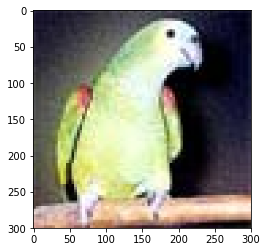

[[[ 46  42  67]
  [ 35  31  56]
  [ 33  29  54]
  ...
  [ 16  16  40]
  [ 19  20  41]
  [ 25  26  47]]

 [[ 33  29  54]
  [ 23  19  44]
  [ 23  19  44]
  ...
  [  2   2  26]
  [  5   6  27]
  [ 12  13  34]]

 [[ 30  26  51]
  [ 21  17  42]
  [ 22  18  41]
  ...
  [  0   0  24]
  [  5   6  27]
  [ 14  15  35]]

 ...

 [[228 187 181]
  [220 179 173]
  [229 186 179]
  ...
  [ 44  20  10]
  [ 48  24  14]
  [ 56  32  22]]

 [[214 165 158]
  [211 162 155]
  [226 178 168]
  ...
  [  6   0   0]
  [  8   1   0]
  [ 19  12   6]]

 [[215 162 154]
  [200 148 137]
  [202 150 139]
  ...
  [ 13  15  14]
  [ 21  21  19]
  [ 34  34  32]]]


In [59]:
image = cv2.cvtColor(cv2.imread('n01503061_1584.JPEG'), cv2.COLOR_BGR2RGB)
plt.imshow(cv2.resize(image, (300,300), interpolation = cv2.INTER_AREA))
plt.savefig('bird.JPEG', bbox_inches = 'tight')
plt.show()
print(image)

As we can see, the data is still extractable from the hdf5 file and is still scaled in a normalized fashion \[0-1\]. Even though it is normalized, the image still renders properly. Take note how grainy the image is. This is due to reshaping of all images to a 300x300x3 array. 

In [35]:
X_train, y_train = data['X_train'], data['y_train']

In [6]:
y_train = [y.reshape(-1) for y in y_train]

In [7]:
X_test, y_test = data['X_test'], data['y_test']

In [37]:
y_test = [y.reshape(-1) for y in y_test]

In [40]:
683*2

1366

Now let's visually inspect the split of the training data to ensure that one or more of the classes isn't improperly imbalanced with respect to all other classes. If it is, then we can just use a different random state in the train test split function in the load_data class

In [65]:
categories = ['dog','bird','stove','car']

In [66]:
y = np.unique([y.argmax() for y in y_train], return_counts = True)

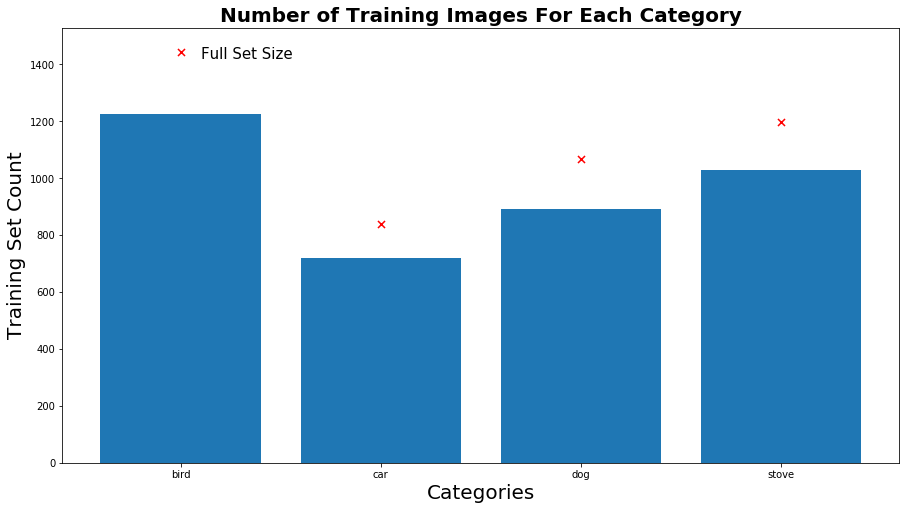

In [73]:
plt.figure(figsize = (15,8))
plt.bar(categories, y[1])
plt.xlabel('Categories',  size =20)
plt.ylabel('Training Set Count', size = 20)
plt.title('Number of Training Images For Each Category', weight = 'bold', size =20)
plt.scatter(range(4), [1445,839,1069,1196], marker = 'x', color = 'r',s = 50)
plt.text(0.1, 1420, 'Full Set Size',size=15)
plt.savefig('cat_hist.JPEG', bbox_inches = 'tight')
plt.show()

The Train Test split appears to be reasonable. No one class is more overloaded than the other with respect to how many images there were in each class total. Now we can start building our tensorflow graph for a Convolutional Neural Network (CNN)

# Convolutional and Pooling Filter

#### Convolution
---------------------------------------
Also known as a filter, is a (m x n) matrix that is overlaid an (M x N) image. The filter (m x n) < the image (M x N). The image below helps illustrate this notion

<img src="images/convolve.png" width="500" />

The top left corner of filter K is initially aligned with the top left corner of image I. The values of I are the pixel values for the image. The overlaid filter values are then multiplied with their corresponding pixel cell, and then all the values are summed together. The filter is then slid over by one column and the operation starts again. Once the filter has gone as far right as possible, it then resets to the left and shifts down one row. It then repeats the same process until it has convolved on the whole image. As shown, the resulting output shrinks the image by a factor of:
> (n1 - f1 + 1) x (n2 -f2 + 1)

Where n1 & n2 is the pixel height & width of the image respectively, f1 & f2 are the height and width of the filter respectively. As seen above, the image is a 7x7 image with a 3x3 filter being applied. The resulting output is:
> (7 - 3 + 1) x (7 - 3 + 1) = 5x5 resulting output

So what is this filter doing? It is basically an edge detector/feature extractor. Since the filter is multiplying the pixel values and summing the result, the areas with high pixel intensity will be amplified and areas with low pixel intensity will be attenuated. The orientation of this amplification/attenuation depends on the orientation of the filter. Let's look at a Vertical Edge Detector example taken from Andrew Ng's CNN deep learning Course for an illustration of whats going on

<img src="images/edge_detect.png" width="800" height="800"/>

As illustrated above, the first 3 columns have pixel intensity 10 and the last 3 have pixel intensity 0. This results in the image seen below it. The left side of the image is white where the right side of the image is gray, with an obvious edge boundary between the two. As the filter convolves around the image, it reduces to pixel values to 0 everywhere except for where the edge existed between the two pixel intensities. This filter is a vertical edge detector. If this filter was rotated 90 degrees, it would then become a horizontal edge detector. Let's apply this filter on one of our images

##### TF Placeholders

In [9]:
x = tf.placeholder(dtype = tf.float64, shape = [None, 300, 300, 3], name = 'X')
y = tf.cast(tf.placeholder(dtype = tf.float64, shape = [None, 4], name = 'Y'), dtype = tf.int32)

Construct the following filter: Vertical Edge Detector

|   |   |   |
|---|---|---|
|  1 | 0  | -1  |
|  1 |  0 |   -1|
|  1 |   0| -1  |

Construct the following filter: Horizontal Edge Detector

|   |   |   |
|---|---|---|
|  1 | 1  | 1  |
|  0 |  0 |   0|
|  -1 |   -1| -1  |

In [10]:
filters = np.zeros(shape=(3,3,3,2), dtype = np.float64)
filters[:,2,:,0] = 1 #vertical line
filters[:,0,:,0] = -1
filters[2,:,:,1] = 1 #horizontal line
filters[0,:,:,1] = -1

##### Create Convolutional Graph

In [11]:
with tf.name_scope('Convolutional_Layers'):
    convolution = tf.nn.conv2d(input = x, filter = filters, strides=[1,1,1,1], padding = 'SAME', name = 'Conv_1')

In [12]:
with tf.name_scope('Max_Pool'):
    max_pool = tf.nn.max_pool(convolution, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID', name = 'Max_Pool',)

In [13]:
with tf.Session() as sess:
    output_con = sess.run(convolution, feed_dict = {x:X_train[0:2]})
    output_pool = sess.run(max_pool, feed_dict = {x:X_train[0:2]})
    

##### Run the CNN and show the output from each filter
------------------------------------------------------
After running an image through the CNN we can see the result of the vertical and horizontal filter on the original image

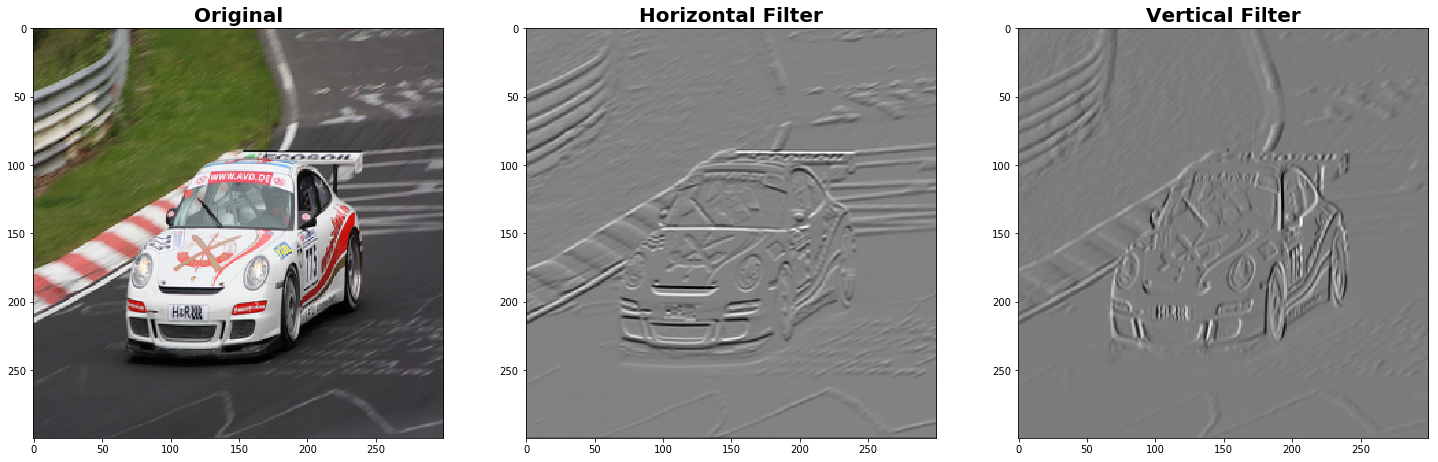

In [22]:
plt.subplots(nrows = 1, ncols = 3, figsize = (25,25))
ax1 = plt.subplot(131)
plt.imshow(X_train[0])
ax1.set_title('Original', weight='bold', size = 20)

ax2 = plt.subplot(132)
plt.imshow(output_con[0,:,:,1], cmap = 'gray')
ax2.set_title('Horizontal Filter', weight='bold', size = 20)

ax3 = plt.subplot(133)
plt.imshow(output_con[0,:,:,0], cmap = 'gray')
ax3.set_title('Vertical Filter', weight='bold', size = 20)
plt.savefig('images/conv_filter.jpeg', bbox_inches = 'tight')
plt.show()


The images are fed in as 300x300x3 arrays. Notice that the output of these images retain this 300x300 shape. This is due to padding

In [18]:
output_con[0,:,:,1].shape

(300, 300)

<img src="images/pad.png" width="800" height="800"/>

As explained above, padding is the act of taking our (M x N) image (300x300) in this case and adding extra rows and columns of 0 values around it. This is done because when convolving the filter around the image, the middle pixel values are are involved in several instances of the convolutional process. The pixels on the sides however are convolved on less frequently due to their position at the borders. Because of this, a lot of information at the borders are lost. By adding 0 padding, we are able to convolve on these border pixesl more often, thus preserving information at the borders. Padding also serves as a way to control output of the convolutional layers. If we need a specific output size, we can ensure we get it by incorporating padding

#### Pooling Layer
-----------------------------------------
A very common practice after feeding an image into a convolutional layer (applying the convolutional filter) is to then feed that output into what is known as a **Pooling Layer**. This layer acts as yet another fitler. There are two types of pooling layers; Max pooling or Average pooling. I'll discuss Max pooling, but the idea of average pooling can be inferred from the explanation 

<img src="images/pool.png" width="500" height="500"/>

A max pool filter simply overlays a filter on the image as shown above and simply returns the largest value in the filter. The filter is then slid over by a predetermined amount of cols and the step is repeated. This pooling layer is used for 2 different reasons
1. It reduces the dimensionality of the data. The pool layer is a non trainable layer that simply takes the highest value in an array. As seen above we are reducing the size of our image (in that example) by 75%. This well have great computational effects during training. However there is an inherent issue with this. We are throwing away 3/4 of our data. 
2. The model needs to be invariant to small perturbations in the data. The model shouldn't be trained so precisely that it looks for an exact pixel in an exact location. It should generalize well to any image with the object of interest in any orientation, size and shape. The pooling layer injects this variance into the model. The convolution layer tries to identify some important structure in some region of the data while the pooling layer obscures the exact location of this structure.

In [23]:
plt.subplots(nrows = 1, ncols = 3, figsize = (25,25))
ax = plt.subplot(131)
plt.imshow(X_train[0])

ax1 = plt.subplot(132)
plt.imshow(output_pool[0,:,:,0], cmap='gray')


ax2 = plt.subplot(133)
plt.imshow(output_pool[0,:,:,1], cmap = 'gray')
plt.savefig('images/pool_filter.jpeg', bbox_inches = 'tight')
plt.show()

In [20]:
output_pool[0,:,:,1].shape

(150, 150)

As we can see above, the results from the convolutional layer is fed into the pooling layer and we are still left with basically the same features and edges that were extracted, but now the location of these featurs have changed. The output size of the images now are 150x150. And this is the simple premise of a CNN. Filters convolved around an image searching for features and edges. I specifically choose the filters I wanted to use for this demonstration. But in the context of a real CNN, those filters will be learned during training (excluding the pooling layer). Each filter learned will be responsible for searching for specific features in various orientations 

#### Strides
-----------------------------

Until now we've gone on the priciple that we slide the filter in each direction by only 1 column or row. This doesn't have to be the case. You can increase how many positions this filter moves by designating the "strides" of the filter. The image below shows the implementation of a 3x3 filter with a stride of 2. It is now not uncommon in more recent CNNs to remove the use of a pool layer all together in favor of just increasing strides on the convolutional layer. It serves the same purpsoe of introducing invariance into the model, but now has the downside of bearing weights that need to be saved in memory and trained. This can make it computationally expensive in comparison to a pooling layer. Note: now with incorporating strides, the resulting image shape equation shown above needs to be modified. With both padding and strides, the resulting image size is now:
> $\frac{n + 2p - f}{s}$ x $\frac{n + 2p -f}{s}$

where:
* p --> padding
* f --> filter
* n --> pixel height & width
* s --> strides

<img src="images/strides.jpg" width="500" height="500"/>

 # Building A Custom TensorFlow CNN Model Class
 ----------------------------------------
 We will build a CNN with 3 Convolutional layers. Layers 1 & 3 with end with a pooling layer while layer 2 will not

In [106]:
class cnnModel:
    def __init__(self, savefile=None, weight_initializer = tf.contrib.layers.xavier_initializer(seed =0), learning_rate=0.01, beta = 0.01):
        
        #Create save file path variable
        self.savefile = savefile
        #Reset any current graphs
        tf.reset_default_graph()
        #Set Random Seed
        np.random.seed(0)
        
        #Print Useful Model Information
        print('Creating CNN Graph')
        print('Tensorboard Log files stored in ./tf_logs/RGB/')
        print('To Activate Tensorboard Session: $tensorboard --logdir "./tf_logs/RGB/" --port 6006')
        print('Optimizer Learning Rate: {}'.format(learning_rate))
        print('L2 Regularization Constant: {}'.format(beta))
        
        if savefile is not None:
            print('Model Save Directory: {}\n'.format(os.path.join(os.getcwd(),savefile)))
        else:
            print('WARNING: No save directory - Model and Weights will be lost after training\n')
        
        
        #Placeholders
        self.inputs = tf.cast(tf.placeholder(dtype = tf.float64, shape = [None, 300,300,3], name = 'X'), tf.float32)
        self.labels = tf.cast(tf.placeholder(dtype = tf.float64, shape = [None,4], name = 'y'), tf.float32)
        self.hold_prob = tf.placeholder(tf.float32)
        
        #Convolutional Layer #1
        with tf.name_scope('Convolution_layer_1'):
            self.W1 = tf.get_variable(dtype = tf.float32, name = 'W1', shape = [7,7,3,10], initializer=weight_initializer)
            self.b1 = tf.Variable(tf.constant(0.1, shape = [10]))
            self.C1 = tf.nn.conv2d(input = self.inputs, filter=self.W1, strides = [1,2,2,1], padding='SAME', name = 'C1')
            self.A1 = tf.nn.relu(features = self.C1, name = 'A1') + self.b1
            self.P1 = tf.nn.max_pool(self.A1, ksize = [1,2,2,1], padding = 'VALID', strides = [1,2,2,1], name = 'Pool_1')

        #Convolutional Layer #2
        with tf.name_scope('Convolution_layer_2'):
            self.W2 = tf.get_variable(dtype = tf.float32, name = 'W2', shape = [4,4,self.P1.shape[3],10], initializer=weight_initializer)
            self.b2 = tf.Variable(tf.constant(0.1, shape = [10]))
            self.C2 = tf.nn.conv2d(input = self.P1, filter = self.W2, strides = [1,2,2,1], padding = 'SAME', name = 'C2')
            self.A2 = tf.nn.relu(features = self.C2 , name = 'A2') + self.b2

        #Convolutional Layer #3
        with tf.name_scope('Convolution_layer_3'):
            self.W3 = tf.get_variable(dtype = tf.float32, name = 'W3', shape = [3,3,self.A2.shape[3],20], initializer=weight_initializer)
            self.b3 = tf.Variable(tf.constant(0.1, shape = [20]))
            self.C3 = tf.nn.conv2d(input = self.A2, filter = self.W3, strides = [1,3,3,1], padding = 'SAME', name = 'C3')
            self.A3 = tf.nn.relu(features = self.C3, name = 'A3') + self.b3
            self.P3 = tf.nn.max_pool(value = self.A3, ksize = [1,2,2,1], padding = 'VALID', strides = [1,2,2,1], name = 'Pool_3')

        #Fully Connected Layer
        with tf.name_scope('Fully_connected_layer'):
            self.flatten = tf.contrib.layers.flatten(self.P3)
            self.Z1 = tf.contrib.layers.fully_connected(self.flatten, num_outputs = 4, activation_fn = None)
            self.hold_out_fc = tf.nn.dropout(self.Z1, keep_prob = self.hold_prob)

        #Prediction Operation
        with tf.name_scope('Prediction_Op'):
            self.predictions = tf.argmax(tf.nn.softmax(logits = self.hold_out_fc), 1)
            self.correct_prediction = tf.equal(self.predictions, tf.argmax(self.labels, 1))
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, "float"))
            
        #Training Operation   
        with tf.name_scope('Training_Op'):
            self.regularizers = tf.nn.l2_loss(self.W1) + tf.nn.l2_loss(self.W2) + tf.nn.l2_loss(self.W3)
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.Z1, labels = self.labels))
            self.cost = tf.reduce_mean(self.loss + (beta * self.regularizers)) 
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)
            
            
            
        #Gloabal Variables Initializer
        with tf.name_scope('Initializers'):
            self.init = tf.global_variables_initializer()
            self.saver = tf.train.Saver(max_to_keep=500, filename='Step_number')
        
        #Log Files for Tensorboard Viewing
        with tf.name_scope('Log_Writers'):
            cost_summary_1 = tf.summary.scalar('Cost', self.cost)
            accuracy_summary = tf.summary.scalar('Accuracy', self.accuracy)
            weights_summary1 = tf.summary.histogram('Weights_1',self.W1)
            weights_summary2 = tf.summary.histogram('Weights_2',self.W2)
            weights_summary3 = tf.summary.histogram('Weights_3',self.W3)
            conv1_summary_channels_1 = tf.summary.image('First_Conv_Layer_1',self.C1[:,:,:,0:1], max_outputs = 2)
            conv1_summary_channels_2 = tf.summary.image('First_Conv_Layer_2',self.C1[:,:,:,1:2], max_outputs = 2)
            conv1_summary_channels_3 = tf.summary.image('First_Conv_Layer_3',self.C1[:,:,:,2:3], max_outputs = 2)
            conv1_summary_channels_4 = tf.summary.image('First_Conv_Layer_4',self.C1[:,:,:,3:4], max_outputs = 2)
            conv1_summary_channels_5 = tf.summary.image('First_Conv_Layer_5',self.C1[:,:,:,4:5], max_outputs = 2)
            conv1_summary_channels_6 = tf.summary.image('First_Conv_Layer_6',self.C1[:,:,:,5:6], max_outputs = 2)
            conv1_summary_channels_7 = tf.summary.image('First_Conv_Layer_7',self.C1[:,:,:,6:7], max_outputs = 2)
            conv1_summary_channels_8 = tf.summary.image('First_Conv_Layer_8',self.C1[:,:,:,7:8], max_outputs = 2)
            conv1_summary_channels_9 = tf.summary.image('First_Conv_Layer_9',self.C1[:,:,:,8:9], max_outputs = 2)
            conv1_summary_channels_10 = tf.summary.image('First_Conv_Layer_10',self.C1[:,:,:,9:10], max_outputs = 2)

            conv2_summary_channels_1 = tf.summary.image('Second_Conv_Layer_1',self.C2[:,:,:,0:1], max_outputs = 2)
            conv2_summary_channels_2 = tf.summary.image('Second_Conv_Layer_2',self.C2[:,:,:,1:2], max_outputs = 2)
            conv2_summary_channels_3 = tf.summary.image('Second_Conv_Layer_3',self.C2[:,:,:,2:3], max_outputs = 2)
            conv2_summary_channels_4 = tf.summary.image('Second_Conv_Layer_4',self.C2[:,:,:,3:4], max_outputs = 2)
            conv2_summary_channels_5 = tf.summary.image('Second_Conv_Layer_5',self.C2[:,:,:,4:5], max_outputs = 2)
            conv2_summary_channels_6 = tf.summary.image('Second_Conv_Layer_6',self.C2[:,:,:,5:6], max_outputs = 2)
            conv2_summary_channels_7 = tf.summary.image('Second_Conv_Layer_7',self.C2[:,:,:,6:7], max_outputs = 2)
            conv2_summary_channels_8 = tf.summary.image('Second_Conv_Layer_8',self.C2[:,:,:,7:8], max_outputs = 2)
            conv2_summary_channels_9 = tf.summary.image('Second_Conv_Layer_9',self.C2[:,:,:,8:9], max_outputs = 2)
            conv2_summary_channels_10 = tf.summary.image('Second_Conv_Layer_10',self.C2[:,:,:,9:10], max_outputs = 2)

            conv3_summary_channels_1 = tf.summary.image('Third_Conv_Layer_1',self.C3[:,:,:,0:1], max_outputs = 2)
            conv3_summary_channels_2 = tf.summary.image('Third_Conv_Layer_2',self.C3[:,:,:,1:2], max_outputs = 2)
            conv3_summary_channels_3 = tf.summary.image('Third_Conv_Layer_3',self.C3[:,:,:,2:3], max_outputs = 2)
            conv3_summary_channels_4 = tf.summary.image('Third_Conv_Layer_4',self.C3[:,:,:,3:4], max_outputs = 2)
            conv3_summary_channels_5 = tf.summary.image('Third_Conv_Layer_5',self.C3[:,:,:,4:5], max_outputs = 2)
            conv3_summary_channels_6 = tf.summary.image('Third_Conv_Layer_6',self.C3[:,:,:,5:6], max_outputs = 2)
            conv3_summary_channels_7 = tf.summary.image('Third_Conv_Layer_7',self.C3[:,:,:,6:7], max_outputs = 2)
            conv3_summary_channels_8 = tf.summary.image('Third_Conv_Layer_8',self.C3[:,:,:,7:8], max_outputs = 2)
            conv3_summary_channels_9 = tf.summary.image('Third_Conv_Layer_9',self.C3[:,:,:,8:9], max_outputs = 2)
            conv3_summary_channels_10 = tf.summary.image('Third_Conv_Layer_10',self.C3[:,:,:,9:10], max_outputs = 2)
            conv3_summary_channels_11 = tf.summary.image('Third_Conv_Layer_11',self.C3[:,:,:,10:11], max_outputs = 2)
            conv3_summary_channels_12 = tf.summary.image('Third_Conv_Layer_12',self.C3[:,:,:,11:12], max_outputs = 2)
            conv3_summary_channels_13 = tf.summary.image('Third_Conv_Layer_13',self.C3[:,:,:,12:13], max_outputs = 2)
            conv3_summary_channels_14 = tf.summary.image('Third_Conv_Layer_14',self.C3[:,:,:,13:14], max_outputs = 2)
            conv3_summary_channels_15 = tf.summary.image('Third_Conv_Layer_15',self.C3[:,:,:,14:15], max_outputs = 2)
            conv3_summary_channels_16 = tf.summary.image('Third_Conv_Layer_16',self.C3[:,:,:,15:16], max_outputs = 2)
            conv3_summary_channels_17 = tf.summary.image('Third_Conv_Layer_17',self.C3[:,:,:,16:17], max_outputs = 2)
            conv3_summary_channels_18 = tf.summary.image('Third_Conv_Layer_18',self.C3[:,:,:,17:18], max_outputs = 2)
            conv3_summary_channels_19 = tf.summary.image('Third_Conv_Layer_19',self.C3[:,:,:,18:19], max_outputs = 2)
            conv3_summary_channels_20 = tf.summary.image('Third_Conv_Layer_20',self.C3[:,:,:,19:20], max_outputs = 2)

            #Compile all summary reports into one object
            self.merged_summaries = tf.summary.merge_all()
        
        
        
    def fit(self,x,y, num_epochs = 100, batch_size = 50):
        print('********* TRAINING MODEL *********')
        #get total number of batches from input size
        num_of_batches = int(x.shape[0] / batch_size)
        #initialize some needed variables
        prev_cost = 0
        cost_tracker = 0
        #initialize an extra summary writer
        cost_summary_2 = tf.summary.scalar('Cost_2', self.cost)
        accuracy_summary_2 = tf.summary.scalar('Accuracy_2', self.accuracy)
        
        #Run the graph
        with tf.Session() as sess:
            #Initialize all Global Variables
            sess.run(self.init)

            #Initialize log writer for Tensorboard
            writer = tf.summary.FileWriter('tf_logs/RGB/', sess.graph)
            for i in range(num_epochs):
                #Initialize useful variables
                cost = 0
                batch_start = 0
                
                for j in range(num_of_batches):
                    #Train the model and track cost
                    _,c = sess.run([self.optimizer,self.cost], feed_dict={
                                                            self.inputs:x[batch_start:batch_start + batch_size],
                                                            self.labels:y[batch_start:batch_start + batch_size],
                                                            self.hold_prob:0.5
                                                            })
                    
                    batch_start+=batch_size
                    cost+=c
                
                #Check for flat cost values over each iteration
                if np.absolute(cost - prev_cost) <= 0.001:
                    print('Cost has reached floor value @ {} - Terminate learning on Epoch {}'.format(cost,i))
                    break
                
                #Check for increasing cost values over each iteration
                if cost > prev_cost:
                    cost_tracker += 1
                    prev_cost = cost
                    if cost_tracker == 20:
                        self.saver.save(sess, self.savefile,global_step=i)
                    
                        #write log files for tensorboard
                        summary = sess.run(self.merged_summaries, feed_dict = {self.inputs:x, self.labels:y, self.hold_prob:1})
                        writer.add_summary(summary, i)
                        print("Cost has increased 20 Epochs in a row - Terminate learning on Epoch {} with cost value {}".format(i,cost))
                        break
                else:
                    prev_cost = cost
                    cost_tracker = 0
                    
                    
                    
                #Every 10 epochs print cost and write tensorboard logs
                if i%10 == 0:
                    #print the cost
                    print('Cost For Epoch {}: {}'.format(i,cost))
                    
                    #save a checkpoint of the model
                    self.saver.save(sess, self.savefile,global_step=i)
                    
                    #write log files for tensorboard
                    
                    summary = sess.run(self.merged_summaries, feed_dict = {self.inputs:x[:1933], self.labels:y[:1933], self.hold_prob:1})
                    cost_2, accuracy_2 = sess.run([cost_summary_2,accuracy_summary_2], feed_dict = {self.inputs:x[1933:], self.labels:y[1933:], self.hold_prob:1})
                    writer.add_summary(summary, i)
                    writer.add_summary(cost_2,i)
                    writer.add_summary(accuracy_2,i)
        
        
   
            
        
    
    
    def predict(self, x):
        with tf.Session() as sess:
            #Restore last saved model checkpoint
            self.saver.restore(sess, self.savefile)
            #Run feed forward part of the graph for predictions
            preds, w1, w2, w3 = sess.run([self.predictions,self.W1, self.W2, self.W3], feed_dict = {self.inputs:x, self.hold_prob:1})
            results = {'predictions':preds, 'w1':w1, 'w2':w2, 'w3':w3}
            return results
        
        
    def restore_predict(self, x, path):
        with tf.Session() as sess:
            self.saver.restore(sess, path)
            preds, w1, w2, w3 = sess.run([self.predictions,self.W1, self.W2, self.W3], feed_dict = {self.inputs:x, self.hold_prob:1})
            results = {'predictions':preds, 'w1':w1, 'w2':w2, 'w3':w3}
            return results


## TRAIN THE MODEL

In [107]:
rgb = cnnModel(savefile = 'Save/RGB/rgb_LR0.001_B0.01.ckpt', learning_rate = 0.001, beta = 0.01)

Creating CNN Graph
Tensorboard Log files stored in ./tf_logs/RGB/
To Activate Tensorboard Session: $tensorboard --logdir "./tf_logs/RGB/" --port 6006
Optimizer Learning Rate: 0.001
L2 Regularization Constant: 0.01
Model Save Directory: /home/scott/Springboard-Data-Science-Immersive/Capstone 2 Project/Convolutional Network/Save/RGB/rgb_LR0.001_B0.01.ckpt



In [13]:
tick = time.time()
rgb.fit(X_train, y_train, batch_size = 100, num_epochs=300)
tock = time.time()
print('Training Time: {:.2} Hrs'.format((tock-tick) / 3600))

********* TRAINING MODEL *********
Cost For Epoch 0: 56.393243193626404
Cost For Epoch 10: 33.453033566474915
Cost For Epoch 20: 28.99536395072937
Cost For Epoch 30: 26.08820354938507
Cost For Epoch 40: 24.21346092224121
Cost For Epoch 50: 22.26216745376587
Cost For Epoch 60: 20.652452170848846
Cost For Epoch 70: 19.18196678161621
Cost For Epoch 80: 18.13813430070877
Cost For Epoch 90: 16.59916463494301
Cost For Epoch 100: 19.57438513636589
Cost For Epoch 110: 15.554781675338745
Cost For Epoch 120: 14.280955195426941
Cost For Epoch 130: 13.569293588399887
Cost For Epoch 140: 12.49201275408268
Cost For Epoch 150: 11.811666801571846
Cost For Epoch 160: 12.243149876594543
Cost For Epoch 170: 12.886905580759048
Cost For Epoch 180: 14.523427546024323
Cost For Epoch 190: 12.059297308325768
Cost For Epoch 200: 10.73670868575573
Cost For Epoch 210: 11.99514277279377
Cost For Epoch 220: 9.972740978002548
Cost For Epoch 230: 9.729537174105644
Cost For Epoch 240: 15.041848182678223
Cost For Epoch

While training - the tensorflow session saved checkpoints with all weights and bias every 10th iteration. It also saved the cost value for the training set. When viewing these values in tensorboard, it is easy to see that the cost for the training data is decreasing while the accuracy is increasing. We now need to compare that with the test set. Let's create a function that will allow us to pass our test data through all model checkpoints and plot accuracy

In [29]:
def model_accuracy_check(clss, x_train, y_train, x_test, y_test, cmap = None, total = 0):
    y_train = np.argmax(y_train, 1)
    y_test = np.argmax(y_test, 1)
    train = []
    test = []
    for i in range(0,total,10):
        if cmap is 'rgb':
            clss.savefile = 'Save/RGB/rgb_LR0.001_B0.01.ckpt-'+str(i)
            results_train_1 = clss.predict(x_train[:1933])
            results_train_2 = clss.predict(x_train[1933:])
            results_test = clss.predict(x_test)
            predictions_train_1 = results_train_1['predictions']
            predictions_train_2 = results_train_2['predictions']
            predictions_test = results_test['predictions']
            acc_train_1 = accuracy_score(y_train[:1933],predictions_train_1)
            acc_train_2 = accuracy_score(y_train[1933:],predictions_train_2)
            acc_train = np.add(acc_train_1, acc_train_2) / 2
            acc_test = accuracy_score(y_test,predictions_test)
            train.append(acc_train)
            test.append(acc_test)
        if cmap is 'gray':
            clss.savefile = 'Save/JOINED_GRAY/grayscale_LR0.001_B0.01.ckpt-'+str(i)
            results_train_1 = clss.predict(x_train[:3866])
            results_train_2 = clss.predict(x_train[3866:])
            results_test = clss.predict(x_test)
            predictions_train_1 = results_train_1['predictions']
            predictions_train_2 = results_train_2['predictions']
            predictions_test = results_test['predictions']
            acc_train_1 = accuracy_score(y_train[:3866],predictions_train_1)
            acc_train_2 = accuracy_score(y_train[3866:],predictions_train_2)
            acc_train = np.add(acc_train_1, acc_train_2) / 2
            acc_test = accuracy_score(y_test,predictions_test)
            train.append(acc_train)
            test.append(acc_test)

    return train, test

In [102]:
train_scores, test_scores = model_accuracy_check(rgb,X_train,y_train, X_test,y_test)

INFO:tensorflow:Restoring parameters from Save/RGB/rgb_LR0.001_B0.01.ckpt-0
INFO:tensorflow:Restoring parameters from Save/RGB/rgb_LR0.001_B0.01.ckpt-0
INFO:tensorflow:Restoring parameters from Save/RGB/rgb_LR0.001_B0.01.ckpt-0
INFO:tensorflow:Restoring parameters from Save/RGB/rgb_LR0.001_B0.01.ckpt-10
INFO:tensorflow:Restoring parameters from Save/RGB/rgb_LR0.001_B0.01.ckpt-10
INFO:tensorflow:Restoring parameters from Save/RGB/rgb_LR0.001_B0.01.ckpt-10
INFO:tensorflow:Restoring parameters from Save/RGB/rgb_LR0.001_B0.01.ckpt-20
INFO:tensorflow:Restoring parameters from Save/RGB/rgb_LR0.001_B0.01.ckpt-20
INFO:tensorflow:Restoring parameters from Save/RGB/rgb_LR0.001_B0.01.ckpt-20
INFO:tensorflow:Restoring parameters from Save/RGB/rgb_LR0.001_B0.01.ckpt-30
INFO:tensorflow:Restoring parameters from Save/RGB/rgb_LR0.001_B0.01.ckpt-30
INFO:tensorflow:Restoring parameters from Save/RGB/rgb_LR0.001_B0.01.ckpt-30
INFO:tensorflow:Restoring parameters from Save/RGB/rgb_LR0.001_B0.01.ckpt-40
IN

In [103]:
plt.figure(figsize = (15,8))
plt.plot(range(0,300,10), train_scores,label = 'Train', marker = 'x' )
plt.plot(range(0,300,10), test_scores, label = 'Test', marker = 'x')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [44]:
print('Training Set Highest Accuracy: {}\nEpoch: {}\nAccuracy on Test Sets Highest Accuracy Epoch {}'.format(max(train_scores), np.argmax(train_scores)*10, train_scores[5]))

Training Set Highest Accuracy: 0.962493533367822
Epoch: 280
Accuracy on Test Sets Highest Accuracy Epoch 0.8101396792550439


In [45]:
print('Test Set Highest Accuracy: {}\nEpoch: {}\nAccuracy on Training Sets Highest Accuracy Epoch {}'.format(max(test_scores), np.argmax(test_scores)*10, test_scores[28]))

Test Set Highest Accuracy: 0.7218155197657394
Epoch: 50
Accuracy on Training Sets Highest Accuracy Epoch 0.705710102489019


We can see that the test set accuracy began to increase with each epoch, but then it plateaued around 70% after Epoch 50. Meanwhile the training set continued to improve. From above, the training set reached 96% accuracy after Epoch 280 of 300. This 96% is great, but the model was starting to overfit the training data. Not only that, but it took 6.3 hours to reach 300 Epochs. Let's explore further results and statistics

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns

def show_results(results, x_tested, y_true, idx_start, idx_stop):
    predictions = results['predictions']
    w1 = results['w1']
    w2 = results['w2']
    w3 = results['w3']
    x = x_tested[idx_start:idx_stop]
    y = np.argmax(y_true, 1)
    size = x.shape[0]
    
    mapper = {0:'Dog', 1:'Bird', 2:'Stove', 3:'Car'}
    
    
    acc = accuracy_score(y,predictions)
    
    
    prec, rec, fbeta, supp = precision_recall_fscore_support(y,predictions)
    metrics = pd.DataFrame({'Precision':prec, 'Recall':rec, 'F-Beta':fbeta, 'Support':supp}, index=['Dog','Bird','Stove','Car'])
    conf_matrix = confusion_matrix(y, predictions)
    
    

    
    def plot_it(data):
        plt.imshow(np.squeeze(data), cmap = 'gray')
        plt.show()
        return None
    
    for i in range(size):
        
        plot_it(x[i])
        print('This is a {}'.format(mapper[predictions[idx_start+i]]))
                           

    print('\nAccuracy: {}%'.format(acc*100))
    sns.heatmap(conf_matrix, annot=True,annot_kws={"size": 10})
    plt.title('Confusion Matrix')
    plt.xlabel('Classes')
    return metrics

## Training Set Results

In [108]:
rgb.savefile = 'Save/RGB/rgb_LR0.001_B0.01.ckpt-280'
results = rgb.predict(X_train[:2000])

INFO:tensorflow:Restoring parameters from Save/RGB/rgb_LR0.001_B0.01.ckpt-280


This is a Bird


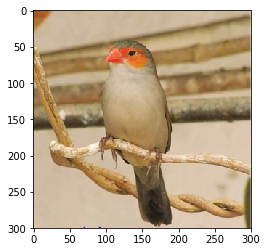

This is a Bird


This is a Stove


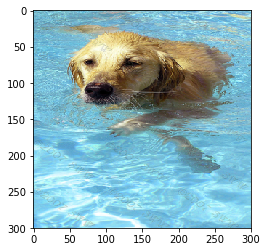

This is a Dog

Accuracy: 96.1%


F-Beta  Precision    Recall  Support
Dog    0.949079   0.920168  0.979866      447
Bird   0.950666   0.985390  0.918306      661
Stove  0.963740   0.942164  0.986328      512
Car    0.989362   1.000000  0.978947      380

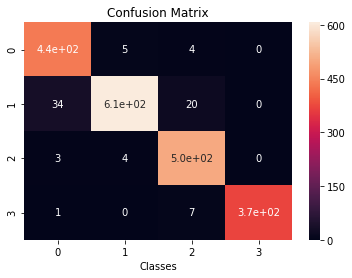

In [110]:
show_results(results, X_train[:2000],y_train[:2000], 424, 428)

## Test Set Results

INFO:tensorflow:Restoring parameters from Save/RGB/rgb_LR0.001_B0.01.ckpt-50


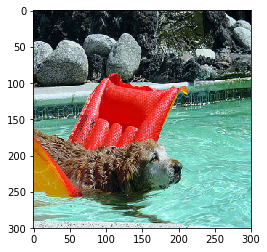

This is a Bird


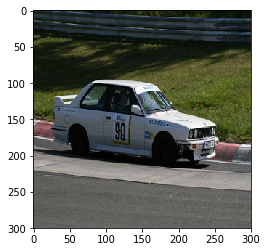

This is a Car


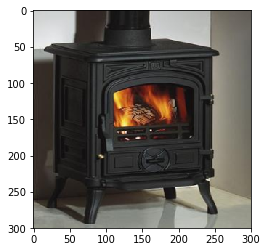

This is a Stove


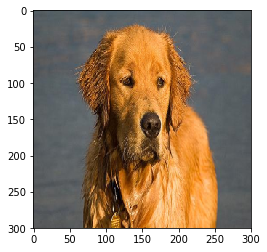

This is a Dog

Accuracy: 72.18155197657394%


F-Beta  Precision    Recall  Support
Dog    0.793003   0.824242  0.764045      178
Bird   0.706935   0.692982  0.721461      219
Stove  0.684932   0.631313  0.748503      167
Car    0.701422   0.804348  0.621849      119

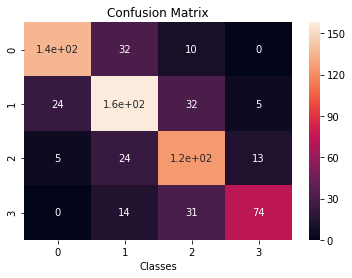

In [113]:
rgb.savefile = 'Save/RGB/rgb_LR0.001_B0.01.ckpt-50'
results = rgb.predict(X_test)
show_results(results, X_test,y_test, 43, 47)

 The best model on the training set performed amazing, with high precision and Accuracy for all 4 categories. It is even resulting in perfect precision when classifying cars. The test set metrics are too bad either. It is a decent car and dog classifier. It still took 6.3 hours to achieve these results and we do have an "overfitting" problem. To test several different model variations would take days. Let's see if we can speed up the training process on the same model while still achieving the same, or better, results

# Grayscale
-------------------------
An image is converted from RGB to grayscale most commonly by taking the average of the 3 pixel color intensities and converting them to a single value. Therefore, we are reducing our size constraints for each image by 2/3. This is removing some of the "information" contained in the data, but since CNN are mostly edge and shape detectors, hopefully this loss of information doesn't translate to a loss of performance. The intrinsic shape of the object in the image is preserved, but the color is just removed

In [9]:
xg = data['X_grayscale_train']
y = data['y_train']
y_train = [x.reshape(-1) for x in y]
xg_test = data['X_grayscale_test']

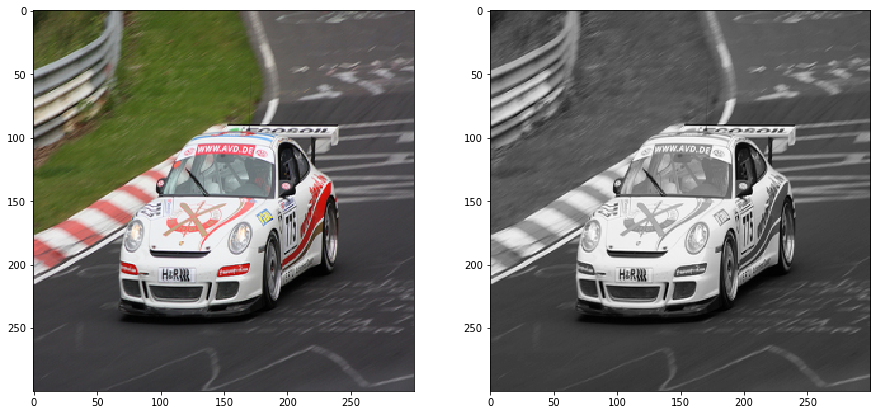

In [119]:
plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plt.subplot(121)
plt.imshow(np.squeeze(X_train[0]))
plt.subplot(122)
plt.imshow(np.squeeze(xg[0]),cmap = 'gray')
plt.savefig('color_gray.JPEG', bbox_inches = 'tight')
plt.show()

In [123]:
print(xg[0].shape)
print(X_train[0].shape)
print(300*300*32 / 8)
print(300*300*3 * 32 / 8)

(300, 300, 1)
(300, 300, 3)
360000.0
1080000.0


In [22]:
class cnnGrayScale:
    def __init__(self, savefile=None, weight_initializer = tf.contrib.layers.xavier_initializer(seed =0), learning_rate=0.01, beta = 0.01):
        
        #Create save file path variable
        self.savefile = savefile
        #Reset any current graphs
        tf.reset_default_graph()
        #Set Random Seed
        np.random.seed(0)
        
        #Print Useful Model Information
        print('Creating CNN Graph')
        print('Tensorboard Log files stored in ./tf_logs/GRAY/')
        print('To Activate Tensorboard Session: $tensorboard --logdir "./tf_logs/GRAY/" --port 6006')
        print('Optimizer Learning Rate: {}'.format(learning_rate))
        print('L2 Regularization Constant: {}'.format(beta))
        
        if savefile is not None:
            print('Model Save Directory: {}\n'.format(os.path.join(os.getcwd(),savefile)))
        else:
            print('WARNING: No save directory - Model and Weights will be lost after training\n')
        
        
        #Placeholders
        self.inputs = tf.cast(tf.placeholder(dtype = tf.float64, shape = [None, 300,300,1], name = 'X'), tf.float32)
        self.labels = tf.cast(tf.placeholder(dtype = tf.float64, shape = [None,4], name = 'y'), tf.float32)
        self.hold_prob = tf.placeholder(tf.float32)
        
        #Convolutional Layer #1
        with tf.name_scope('Convolution_layer_1'):
            self.W1 = tf.get_variable(dtype = tf.float32, name = 'W1', shape = [7,7,1,10], initializer=weight_initializer)
            self.b1 = tf.Variable(tf.constant(0.1, shape = [10]))
            self.C1 = tf.nn.conv2d(input = self.inputs, filter=self.W1, strides = [1,2,2,1], padding='SAME', name = 'C1')
            self.A1 = tf.nn.relu(features = self.C1, name = 'A1') + self.b1
            self.P1 = tf.nn.max_pool(self.A1, ksize = [1,2,2,1], padding = 'VALID', strides = [1,2,2,1], name = 'Pool_1')

        #Convolutional Layer #2
        with tf.name_scope('Convolution_layer_2'):
            self.W2 = tf.get_variable(dtype = tf.float32, name = 'W2', shape = [4,4,self.P1.shape[3],10], initializer=weight_initializer)
            self.b2 = tf.Variable(tf.constant(0.1, shape = [10]))
            self.C2 = tf.nn.conv2d(input = self.P1, filter = self.W2, strides = [1,2,2,1], padding = 'SAME', name = 'C2')
            self.A2 = tf.nn.relu(features = self.C2 , name = 'A2') + self.b2

        #Convolutional Layer #3
        with tf.name_scope('Convolution_layer_3'):
            self.W3 = tf.get_variable(dtype = tf.float32, name = 'W3', shape = [3,3,self.A2.shape[3],20], initializer=weight_initializer)
            self.b3 = tf.Variable(tf.constant(0.1, shape = [20]))
            self.C3 = tf.nn.conv2d(input = self.A2, filter = self.W3, strides = [1,3,3,1], padding = 'SAME', name = 'C3')
            self.A3 = tf.nn.relu(features = self.C3, name = 'A3') + self.b3
            self.P3 = tf.nn.max_pool(value = self.A3, ksize = [1,2,2,1], padding = 'VALID', strides = [1,2,2,1], name = 'Pool_3')

        #Fully Connected Layer
        with tf.name_scope('Fully_connected_layer'):
            self.flatten = tf.contrib.layers.flatten(self.P3)
            self.Z1 = tf.contrib.layers.fully_connected(self.flatten, num_outputs = 4, activation_fn = None)
            self.hold_out_fc = tf.nn.dropout(self.Z1, keep_prob = self.hold_prob)

        #Prediction Operation
        with tf.name_scope('Prediction_Op'):
            self.predictions = tf.argmax(tf.nn.softmax(logits = self.hold_out_fc), 1)
            self.correct_prediction = tf.equal(self.predictions, tf.argmax(self.labels, 1))
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, "float"))
            
        #Training Operation   
        with tf.name_scope('Training_Op'):
            self.regularizers = tf.nn.l2_loss(self.W1) + tf.nn.l2_loss(self.W2) + tf.nn.l2_loss(self.W3)
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.Z1, labels = self.labels))
            self.cost = tf.reduce_mean(self.loss + (beta * self.regularizers)) 
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)
            
            
            
        #Gloabal Variables Initializer
        with tf.name_scope('Initializers'):
            self.init = tf.global_variables_initializer()
            self.saver = tf.train.Saver(max_to_keep=500, filename='Step_number')
        
        #Log Files for Tensorboard Viewing
        with tf.name_scope('Log_Writers'):
            cost_summary_1 = tf.summary.scalar('Cost', self.cost)
            accuracy_summary = tf.summary.scalar('Accuracy', self.accuracy)
            weights_summary1 = tf.summary.histogram('Weights_1',self.W1)
            weights_summary2 = tf.summary.histogram('Weights_2',self.W2)
            weights_summary3 = tf.summary.histogram('Weights_3',self.W3)
            conv1_summary_channels_1 = tf.summary.image('First_Conv_Layer_1',self.C1[:,:,:,0:1], max_outputs = 2)
            conv1_summary_channels_2 = tf.summary.image('First_Conv_Layer_2',self.C1[:,:,:,1:2], max_outputs = 2)
            conv1_summary_channels_3 = tf.summary.image('First_Conv_Layer_3',self.C1[:,:,:,2:3], max_outputs = 2)
            conv1_summary_channels_4 = tf.summary.image('First_Conv_Layer_4',self.C1[:,:,:,3:4], max_outputs = 2)
            conv1_summary_channels_5 = tf.summary.image('First_Conv_Layer_5',self.C1[:,:,:,4:5], max_outputs = 2)
            conv1_summary_channels_6 = tf.summary.image('First_Conv_Layer_6',self.C1[:,:,:,5:6], max_outputs = 2)
            conv1_summary_channels_7 = tf.summary.image('First_Conv_Layer_7',self.C1[:,:,:,6:7], max_outputs = 2)
            conv1_summary_channels_8 = tf.summary.image('First_Conv_Layer_8',self.C1[:,:,:,7:8], max_outputs = 2)
            conv1_summary_channels_9 = tf.summary.image('First_Conv_Layer_9',self.C1[:,:,:,8:9], max_outputs = 2)
            conv1_summary_channels_10 = tf.summary.image('First_Conv_Layer_10',self.C1[:,:,:,9:10], max_outputs = 2)

            conv2_summary_channels_1 = tf.summary.image('Second_Conv_Layer_1',self.C2[:,:,:,0:1], max_outputs = 2)
            conv2_summary_channels_2 = tf.summary.image('Second_Conv_Layer_2',self.C2[:,:,:,1:2], max_outputs = 2)
            conv2_summary_channels_3 = tf.summary.image('Second_Conv_Layer_3',self.C2[:,:,:,2:3], max_outputs = 2)
            conv2_summary_channels_4 = tf.summary.image('Second_Conv_Layer_4',self.C2[:,:,:,3:4], max_outputs = 2)
            conv2_summary_channels_5 = tf.summary.image('Second_Conv_Layer_5',self.C2[:,:,:,4:5], max_outputs = 2)
            conv2_summary_channels_6 = tf.summary.image('Second_Conv_Layer_6',self.C2[:,:,:,5:6], max_outputs = 2)
            conv2_summary_channels_7 = tf.summary.image('Second_Conv_Layer_7',self.C2[:,:,:,6:7], max_outputs = 2)
            conv2_summary_channels_8 = tf.summary.image('Second_Conv_Layer_8',self.C2[:,:,:,7:8], max_outputs = 2)
            conv2_summary_channels_9 = tf.summary.image('Second_Conv_Layer_9',self.C2[:,:,:,8:9], max_outputs = 2)
            conv2_summary_channels_10 = tf.summary.image('Second_Conv_Layer_10',self.C2[:,:,:,9:10], max_outputs = 2)

            conv3_summary_channels_1 = tf.summary.image('Third_Conv_Layer_1',self.C3[:,:,:,0:1], max_outputs = 2)
            conv3_summary_channels_2 = tf.summary.image('Third_Conv_Layer_2',self.C3[:,:,:,1:2], max_outputs = 2)
            conv3_summary_channels_3 = tf.summary.image('Third_Conv_Layer_3',self.C3[:,:,:,2:3], max_outputs = 2)
            conv3_summary_channels_4 = tf.summary.image('Third_Conv_Layer_4',self.C3[:,:,:,3:4], max_outputs = 2)
            conv3_summary_channels_5 = tf.summary.image('Third_Conv_Layer_5',self.C3[:,:,:,4:5], max_outputs = 2)
            conv3_summary_channels_6 = tf.summary.image('Third_Conv_Layer_6',self.C3[:,:,:,5:6], max_outputs = 2)
            conv3_summary_channels_7 = tf.summary.image('Third_Conv_Layer_7',self.C3[:,:,:,6:7], max_outputs = 2)
            conv3_summary_channels_8 = tf.summary.image('Third_Conv_Layer_8',self.C3[:,:,:,7:8], max_outputs = 2)
            conv3_summary_channels_9 = tf.summary.image('Third_Conv_Layer_9',self.C3[:,:,:,8:9], max_outputs = 2)
            conv3_summary_channels_10 = tf.summary.image('Third_Conv_Layer_10',self.C3[:,:,:,9:10], max_outputs = 2)
            conv3_summary_channels_11 = tf.summary.image('Third_Conv_Layer_11',self.C3[:,:,:,10:11], max_outputs = 2)
            conv3_summary_channels_12 = tf.summary.image('Third_Conv_Layer_12',self.C3[:,:,:,11:12], max_outputs = 2)
            conv3_summary_channels_13 = tf.summary.image('Third_Conv_Layer_13',self.C3[:,:,:,12:13], max_outputs = 2)
            conv3_summary_channels_14 = tf.summary.image('Third_Conv_Layer_14',self.C3[:,:,:,13:14], max_outputs = 2)
            conv3_summary_channels_15 = tf.summary.image('Third_Conv_Layer_15',self.C3[:,:,:,14:15], max_outputs = 2)
            conv3_summary_channels_16 = tf.summary.image('Third_Conv_Layer_16',self.C3[:,:,:,15:16], max_outputs = 2)
            conv3_summary_channels_17 = tf.summary.image('Third_Conv_Layer_17',self.C3[:,:,:,16:17], max_outputs = 2)
            conv3_summary_channels_18 = tf.summary.image('Third_Conv_Layer_18',self.C3[:,:,:,17:18], max_outputs = 2)
            conv3_summary_channels_19 = tf.summary.image('Third_Conv_Layer_19',self.C3[:,:,:,18:19], max_outputs = 2)
            conv3_summary_channels_20 = tf.summary.image('Third_Conv_Layer_20',self.C3[:,:,:,19:20], max_outputs = 2)


            self.merged_summaries = tf.summary.merge_all()
        
        
        
    def fit(self,x,y, num_epochs = 100, batch_size = 50):
        print('********* TRAINING MODEL *********')
        num_of_batches = int(x.shape[0] / batch_size)
        prev_cost = 0
        cost_tracker = 0
        cost_summary_2 = tf.summary.scalar('Cost_2', self.cost)
        accuracy_summary_2 = tf.summary.scalar('Accuracy_2', self.accuracy)
        with tf.Session() as sess:
            #Initialize all Global Variables
            sess.run(self.init)

            #Initialize log writer for Tensorboard
            writer = tf.summary.FileWriter('tf_logs/JOINED_GRAY/', sess.graph)
            for i in range(num_epochs):
                #Initialize useful variables
                cost = 0
                batch_start = 0
                
                for j in range(num_of_batches):
                    #Train the model and track cost
                    _,c = sess.run([self.optimizer,self.cost], feed_dict={
                                                            self.inputs:x[batch_start:batch_start + batch_size],
                                                            self.labels:y[batch_start:batch_start + batch_size],
                                                            self.hold_prob:0.5
                                                            })
                    
                    batch_start+=batch_size
                    cost+=c
                    
                if np.absolute(cost - prev_cost) <= 0.001:
                    print('Cost has reached floor value @ {} - Terminate learning on Epoch {}'.format(cost,i))
                    break
                
                if cost > prev_cost:
                    cost_tracker += 1
                    prev_cost = cost
                    if cost_tracker == 20:
                        self.saver.save(sess, self.savefile,global_step=i)
                    
                        #write log files for tensorboard
                        summary = sess.run(self.merged_summaries, feed_dict = {self.inputs:x[:3000], self.labels:y[:3000], self.hold_prob:1})
                        writer.add_summary(summary, i)
                        print("Cost has increased 20 Epochs in a row - Terminate learning on Epoch {} with cost value {}".format(i,cost))
                        break
                else:
                    prev_cost = cost
                    cost_tracker = 0
                    
                    
                    
                #Every 10 epochs, ,  and 
                if i%10 == 0:
                    #print the cost
                    print('Cost For Epoch {}: {}'.format(i,cost))
                    
                    #save a checkpoint of the model
                    self.saver.save(sess, self.savefile,global_step=i)
                    
                    #write log files for tensorboard
                    
                    summary = sess.run(self.merged_summaries, feed_dict = {self.inputs:x[:3866], self.labels:y[:3866], self.hold_prob:1})
                    cost_2, accuracy_2 = sess.run([cost_summary_2,accuracy_summary_2], feed_dict = {self.inputs:x[3866:], self.labels:y[3866:], self.hold_prob:1})
                    writer.add_summary(summary, i)
                    writer.add_summary(cost_2,i)
                    writer.add_summary(accuracy_2,i)
        
        
   
            
        
    
    
    def predict(self, x):
        with tf.Session() as sess:
            #Restore last saved model checkpoint
            self.saver.restore(sess, self.savefile)
            #Run feed forward part of the graph for predictions
            preds, w1, w2, w3 = sess.run([self.predictions,self.W1, self.W2, self.W3], feed_dict = {self.inputs:x, self.hold_prob:1})
            results = {'predictions':preds, 'w1':w1, 'w2':w2, 'w3':w3}
            return results
        
        
    def restore_predict(self, x, path):
        with tf.Session() as sess:
            self.saver.restore(sess, path)
            preds, w1, w2, w3 = sess.run([self.predictions,self.W1, self.W2, self.W3], feed_dict = {self.inputs:x, self.hold_prob:1})
            results = {'predictions':preds, 'w1':w1, 'w2':w2, 'w3':w3}
            return results


In [23]:
gray = cnnGrayScale(savefile='Save/GRAY/grayscale_LR0.001_B0.01.ckpt', learning_rate = 0.001, beta = 0.01)

Creating CNN Graph
Tensorboard Log files stored in ./tf_logs/GRAY/
To Activate Tensorboard Session: $tensorboard --logdir "./tf_logs/GRAY/" --port 6006
Optimizer Learning Rate: 0.001
L2 Regularization Constant: 0.01
Model Save Directory: /home/scott/Springboard-Data-Science-Immersive/Capstone 2 Project/Convolutional Network/Save/GRAY/grayscale_LR0.001_B0.01.ckpt



In [94]:
tick = time.time()
gray.fit(xg,y_train, num_epochs=500, batch_size = 50)
tock = time.time()
print('Training Time: {:.2} Hrs'.format((tock-tick) / 3600))

********* TRAINING MODEL *********
Cost For Epoch 0: 281.5268363952637
Cost For Epoch 10: 66.23307698965073
Cost For Epoch 20: 52.43699708580971
Cost For Epoch 30: 42.89520242810249
Cost For Epoch 40: 31.53335040807724
Cost For Epoch 50: 32.09340810775757
Cost For Epoch 60: 29.46876487135887
Cost For Epoch 70: 23.196930810809135
Cost For Epoch 80: 22.43648038804531
Cost For Epoch 90: 16.892146855592728
Cost For Epoch 100: 17.801722019910812
Cost For Epoch 110: 18.010816603899002
Cost For Epoch 120: 16.198138490319252
Cost For Epoch 130: 17.355459839105606
Cost For Epoch 140: 15.047654047608376
Cost For Epoch 150: 11.359884038567543
Cost For Epoch 160: 12.562332957983017
Cost For Epoch 170: 11.270137302577496
Cost For Epoch 180: 10.977908067405224
Cost For Epoch 190: 8.233059495687485
Cost For Epoch 200: 6.834552899003029
Cost For Epoch 210: 40.1611163020134
Cost For Epoch 220: 10.787826709449291
Cost For Epoch 230: 13.031812973320484
Cost For Epoch 240: 7.820239596068859
Cost For Epoch

In [31]:
def model_accuracy_check(clss, x_train, y_train, x_test, y_test):
    y_train = np.argmax(y_train, 1)
    y_test = np.argmax(y_test, 1)
    train = []
    test = []
    for i in range(0,500,10):
        clss.savefile = 'Save/GRAY/grayscale_LR0.001_B0.01.ckpt-'+str(i)
        
        results_train = clss.predict(x_train)
        results_test = clss.predict(x_test)
        predictions_train = results_train['predictions']
        predictions_test = results_test['predictions']
        acc_train = accuracy_score(y_train,predictions_train)
        acc_test = accuracy_score(y_test,predictions_test)
        train.append(acc_train)
        test.append(acc_test)
    return train, test

In [32]:
train_scores, test_scores = model_accuracy_check(gray,xg,y_train, xg_test,y_test)

INFO:tensorflow:Restoring parameters from Save/GRAY/grayscale_LR0.001_B0.01.ckpt-0
INFO:tensorflow:Restoring parameters from Save/GRAY/grayscale_LR0.001_B0.01.ckpt-0
INFO:tensorflow:Restoring parameters from Save/GRAY/grayscale_LR0.001_B0.01.ckpt-10
INFO:tensorflow:Restoring parameters from Save/GRAY/grayscale_LR0.001_B0.01.ckpt-10
INFO:tensorflow:Restoring parameters from Save/GRAY/grayscale_LR0.001_B0.01.ckpt-20
INFO:tensorflow:Restoring parameters from Save/GRAY/grayscale_LR0.001_B0.01.ckpt-20
INFO:tensorflow:Restoring parameters from Save/GRAY/grayscale_LR0.001_B0.01.ckpt-30
INFO:tensorflow:Restoring parameters from Save/GRAY/grayscale_LR0.001_B0.01.ckpt-30
INFO:tensorflow:Restoring parameters from Save/GRAY/grayscale_LR0.001_B0.01.ckpt-40
INFO:tensorflow:Restoring parameters from Save/GRAY/grayscale_LR0.001_B0.01.ckpt-40
INFO:tensorflow:Restoring parameters from Save/GRAY/grayscale_LR0.001_B0.01.ckpt-50
INFO:tensorflow:Restoring parameters from Save/GRAY/grayscale_LR0.001_B0.01.ck

INFO:tensorflow:Restoring parameters from Save/GRAY/grayscale_LR0.001_B0.01.ckpt-480
INFO:tensorflow:Restoring parameters from Save/GRAY/grayscale_LR0.001_B0.01.ckpt-490
INFO:tensorflow:Restoring parameters from Save/GRAY/grayscale_LR0.001_B0.01.ckpt-490


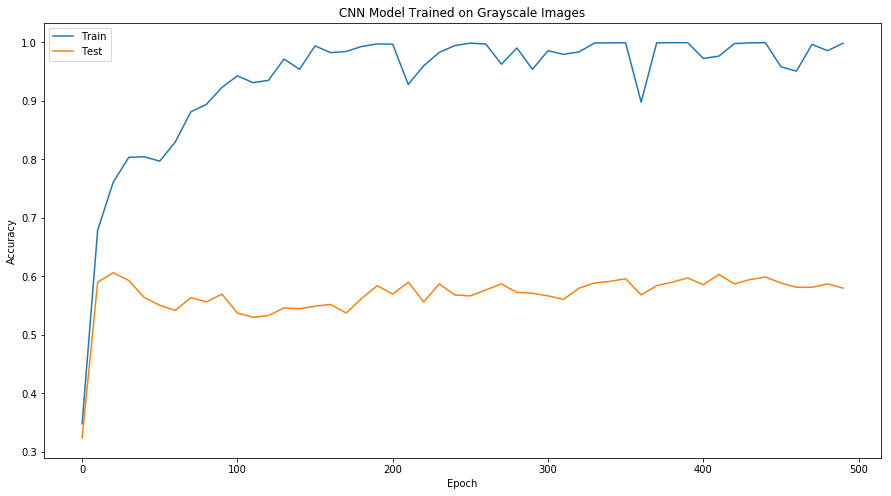

In [56]:
plt.figure(figsize = (15,8))
plt.plot(range(0,500, 10), train_scores,label = 'Train' )
plt.plot(range(0,500, 10), test_scores, label = 'Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Model Trained on Grayscale Images')
plt.show()

In [37]:
print('Training Set Highest Accuracy: {}\nEpoch: {}\nAccuracy on Test Sets Highest Accuracy Epoch {}'.format(max(train_scores), np.argmax(train_scores)*10, train_scores[5]))

Training Set Highest Accuracy: 0.999482669425763
Epoch: 380
Accuracy on Test Sets Highest Accuracy Epoch 0.7969477496120021


In [42]:
print('Test Set Highest Accuracy: {}\nEpoch: {}\nAccuracy on Training Sets Highest Accuracy Epoch {}'.format(max(test_scores), np.argmax(test_scores)*10, test_scores[38]))

Test Set Highest Accuracy: 0.6061493411420205
Epoch: 20
Accuracy on Training Sets Highest Accuracy Epoch 0.5900439238653001


So there's good news and bad news. The Bad news is by converting to Grayscale and using the same CNN architecture, we were only able to achieve 61% accuracy on the test set. Meanwhile we ahcieved 99.9% accuracy on the training set. This means we are grossly overfitting the training data. On the plus side however, with full RGB data, training took 6.3 hours to go 300 Epochs, where as it took only 5.1 hours to go 500 Epochs with the grayscale data. This breaks down to about 36.7 seconds per Epoch for the latter and 75.6 seconds per Epoch for the former. A reduction of 51.4% training time. This will save us some time training various different CNN architectures while tuning hyperparameters to try and attenuate our current overfitting problem. In the mean time, let's look at the metrics of the best performing models a little closer

In [127]:
gray.savefile = 'Save/GRAY/grayscale_LR0.001_B0.01.ckpt-380'
best_training_results = gray.predict(xg)

INFO:tensorflow:Restoring parameters from Save/GRAY/grayscale_LR0.001_B0.01.ckpt-380


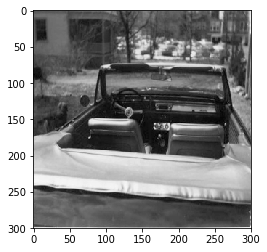

This is a Car


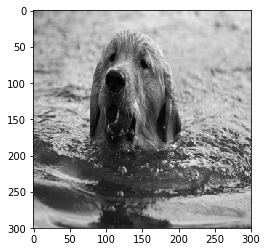

This is a Dog


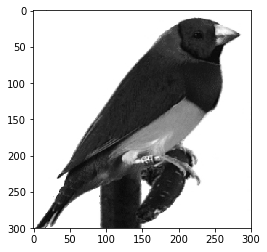

This is a Bird


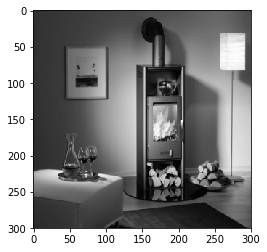

This is a Stove

Accuracy: 99.9482669425763%


F-Beta  Precision    Recall  Support
Dog    0.999439   0.998879  1.000000      891
Bird   0.999592   1.000000  0.999184     1226
Stove  0.999514   0.999029  1.000000     1029
Car    0.999305   1.000000  0.998611      720

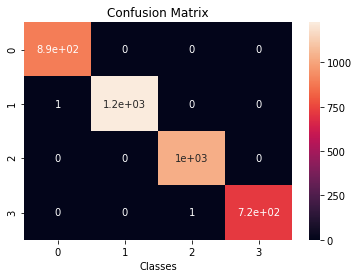

In [129]:
show_results(best_training_results, xg,y_train, 324, 328)

As expected with a result of 99.9% accuracy, the precision and recall for all 4 classes is stellar. More telling information should be extrapolated from the test set metrics

In [131]:
xg_test = data['X_grayscale_test']
y_test = data['y_test']
y_test = [x.reshape(-1) for x in y_test]

In [132]:
gray.savefile = 'Save/GRAY/grayscale_LR0.001_B0.01.ckpt-20'
best_test_results = gray.predict(xg_test)

INFO:tensorflow:Restoring parameters from Save/GRAY/grayscale_LR0.001_B0.01.ckpt-20


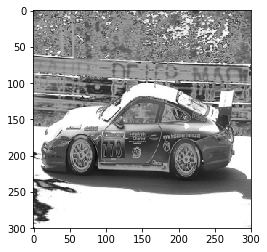

This is a Stove


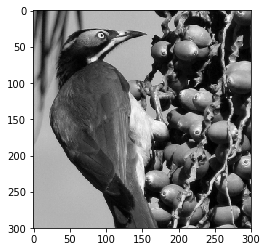

This is a Bird


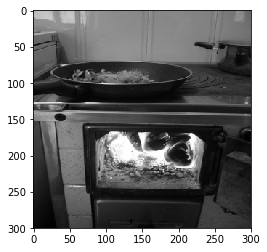

This is a Stove


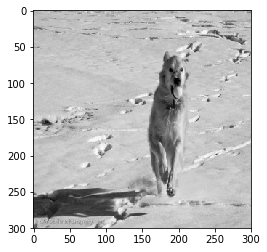

This is a Dog

Accuracy: 60.61493411420204%


F-Beta  Precision    Recall  Support
Dog    0.612903   0.587629  0.640449      178
Bird   0.585903   0.565957  0.607306      219
Stove  0.626582   0.664430  0.592814      167
Car    0.607143   0.647619  0.571429      119

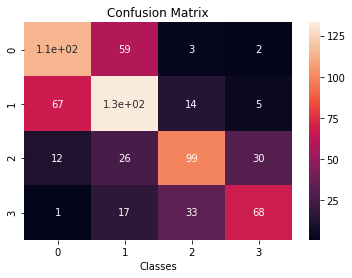

In [133]:
show_results(best_test_results, xg_test, y_test,531,535)

So unfortunately it appears that with a 2/3 in data reduction size comes a 10% accuracy penalty when training the same model with the same data. This isn't suprising since we did reduce data density in the images for the model to learn from. The hope was that even with the reduction in "infromation" the edges of each object in the images would still be defined enough for the model to detect accurately. Since the goal is for the model to learn the edges of dogs, birds, stoves, and cars essentially, maybe we can enhance the grayscale images to make it easier for the model to detect them.

# HISTOGRAM EQUALIZATION
------------------------------
From the University of Utah Image Processing course
> Histogram equalization is a method to process images in order to adjust the contrast of an image by modifying the intensity distribution of the histogram. The objective of this technique is to give a linear trend to the cumulative probability function associated to the image. The processing of histogram equalization relies on the use of the cumulative probability function (cdf). The idea of this processing is to give to the resulting image a linear cumulative distribution function. Indeed, a linear cdf is associated to the uniform histogram that we want the resulting image to have.

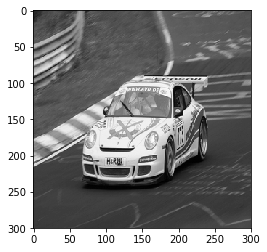

In [10]:
plt.imshow(np.squeeze(xg[0]), cmap = 'gray')
plt.show()

In [11]:
#flatten the pixels into a 1-D array of pixel values
image =  xg[0].reshape(-1)

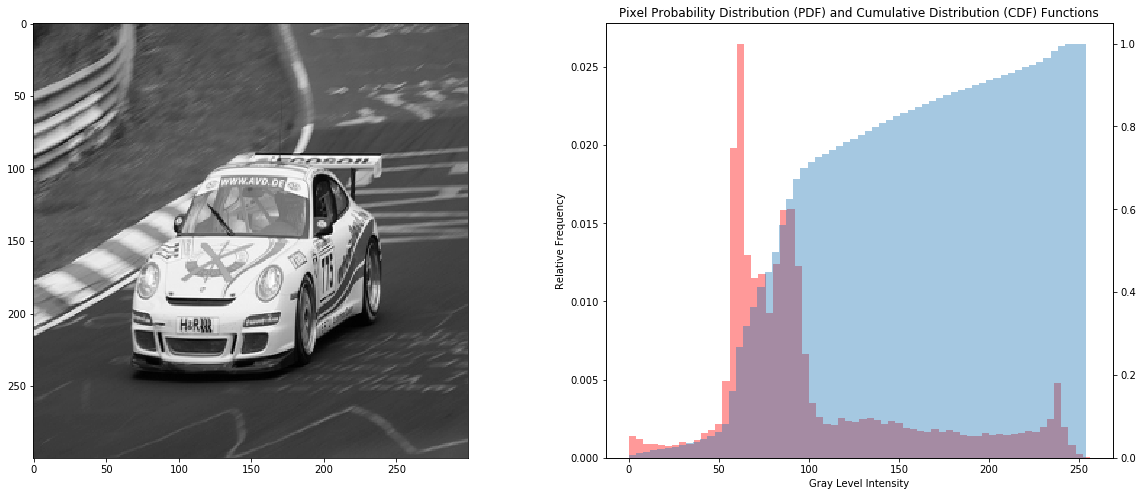

In [15]:
#Display the histogram and CDF of the pixels of the image and extract the bins/CDF values
plt.subplots(nrows=1,ncols=2, figsize=(20,8))
plt.subplot(121)
plt.imshow(np.squeeze(xg[0]),cmap='gray')
plt.subplot(122)
plt.hist(image, bins = 64, normed = True, color='red', alpha = 0.4,range= (0,256) )
plt.ylabel('Relative Frequency')
plt.xlabel('Gray Level Intensity')
plt.title('Pixel Probability Distribution (PDF) and Cumulative Distribution (CDF) Functions')
plt.twinx()
cdf, bins, patches = plt.hist(image, bins = 64, normed = True, cumulative=True, alpha = 0.4)
plt.savefig('cdf.JPEG', bbox_inches = 'tight')
plt.show()

In [17]:
#Interpolate the new pixel intensities of the original image using the CDF
new_pixels = np.interp(image, bins[:-1], cdf*255)
new_image = new_pixels.reshape(xg[0].shape)

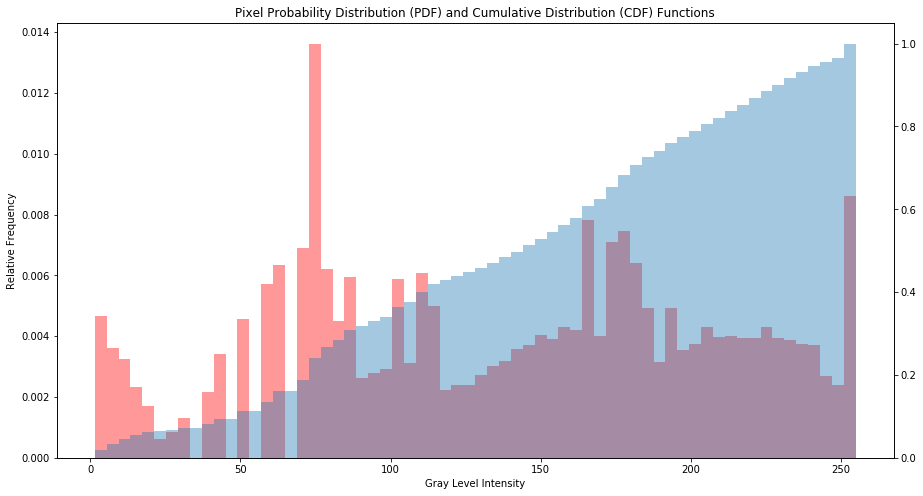

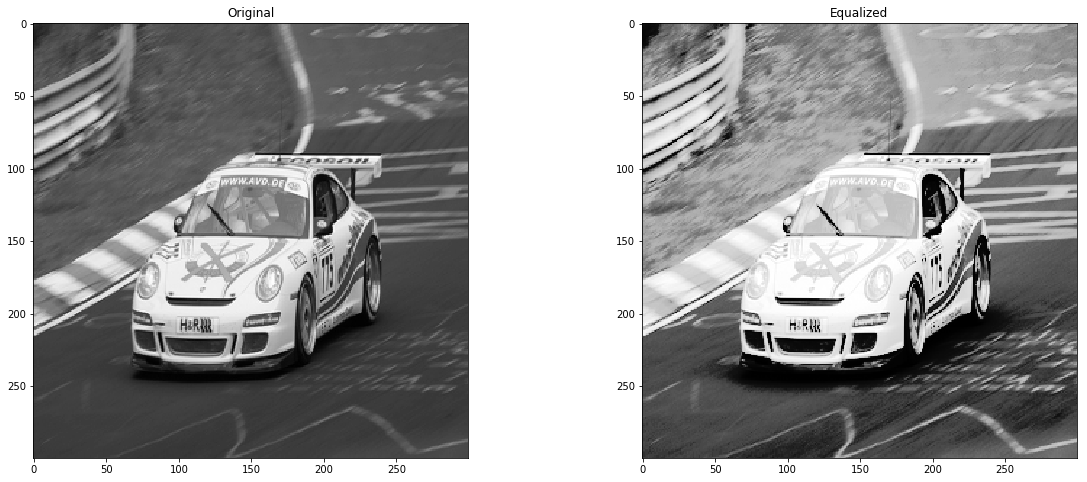

In [18]:
plt.figure(figsize = (15,8))
plt.hist(new_image.reshape(-1), bins = 64, normed = True, color = 'red', alpha =0.4)
plt.ylabel('Relative Frequency')
plt.xlabel('Gray Level Intensity')
plt.title('Pixel Probability Distribution (PDF) and Cumulative Distribution (CDF) Functions')

plt.twinx()
plt.hist(new_image.reshape(-1), bins = 64, normed = True, cumulative=True, alpha = 0.4)
plt.savefig('equalized.JPEG', bbox_inches = 'tight')
plt.show()

plt.subplots(nrows=1,ncols=2, figsize=(20,8))
plt.subplot(121)
plt.imshow(np.squeeze(xg[0]), cmap = 'gray')
plt.title('Original')
plt.subplot(122)
plt.imshow(np.squeeze(new_image), cmap = 'gray')
plt.title('Equalized')
plt.savefig('contrast.JPEG', bbox_inches = 'tight')
plt.show()

### Create a function to Equalize all images

In [27]:
def sharpen_image(images):
    images = [i.reshape(-1) for i in images]
    for i in range(len(images)):
        cdf, bins, patches = plt.hist(images[i], bins = 64, normed = True, cumulative=True, alpha = 0.4)
        plt.close()
        new_pixels = np.interp(images[i], bins[:-1], cdf*255)
        images[i] = new_pixels.reshape(300,300,1)
    return images

### SHARPEN TRAIN SET

In [28]:
sharp_images = sharpen_image(xg)

In [29]:
def side_by_side(orig, new, num = 0):
    plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    plt.subplot(121)
    plt.imshow(np.squeeze(orig[num]), cmap = 'gray')
    
    plt.subplot(122)
    plt.imshow(np.squeeze(new[num]), cmap='gray')
    plt.show()

In [30]:
side_by_side(xg, sharp_images, num=2765)

# PREDICT ON THE EQUALIZED TRAINING IMAGES
-------------------------------------------------
Now that we have sharpened the training images, let's test them on the best performing model for the training set (EPOCH 380) and the best performing model for the test set (EPOCH 20)

In [24]:
sharp = cnnGrayScale(savefile=None)

Creating CNN Graph
Tensorboard Log files stored in ./tf_logs/GRAY/
To Activate Tensorboard Session: $tensorboard --logdir "./tf_logs/GRAY/" --port 6006
Optimizer Learning Rate: 0.01
L2 Regularization Constant: 0.01



### PREDICT ON SHARPENED TRAIN SET

In [31]:
sharp_results = sharp.restore_predict(sharp_images, path = 'Save/GRAY/grayscale_LR0.001_B0.01.ckpt-380')

INFO:tensorflow:Restoring parameters from Save/GRAY/grayscale_LR0.001_B0.01.ckpt-380


This is a Car


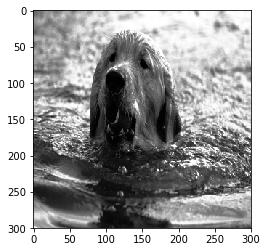

This is a Car


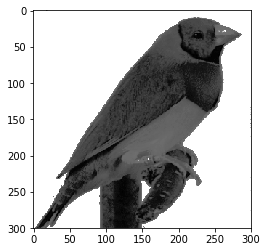

This is a Bird


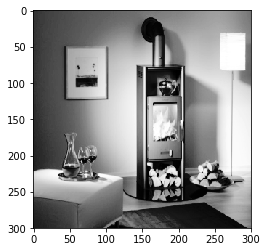

This is a Stove

Accuracy: 78.45318158303157%


F-Beta  Precision    Recall  Support
Dog    0.729229   0.780051  0.684624      891
Bird   0.786156   0.794338  0.778140     1226
Stove  0.828351   0.822010  0.834791     1029
Car    0.783055   0.727924  0.847222      720

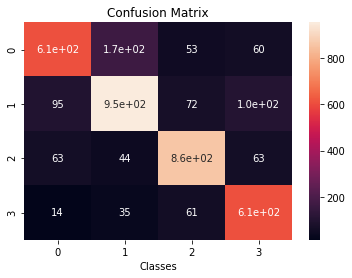

In [32]:
show_results(sharp_results, np.array(sharp_images),y_train, 324, 328)

In [33]:
sharp_results = sharp.restore_predict(sharp_images, path = 'Save/GRAY/grayscale_LR0.001_B0.01.ckpt-20')

INFO:tensorflow:Restoring parameters from Save/GRAY/grayscale_LR0.001_B0.01.ckpt-20


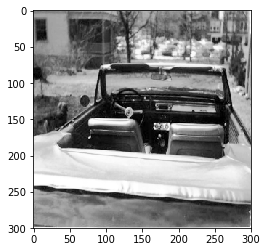

This is a Car


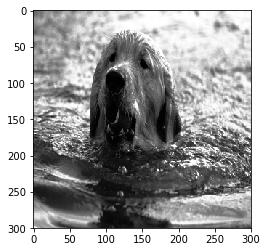

This is a Bird


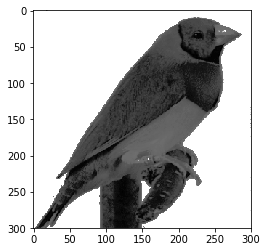

This is a Bird


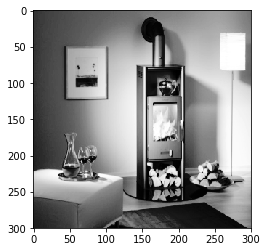

This is a Stove

Accuracy: 61.69167097775479%


F-Beta  Precision    Recall  Support
Dog    0.491468   0.627178  0.404040      891
Bird   0.631658   0.588318  0.681892     1226
Stove  0.694758   0.737186  0.656948     1029
Car    0.612903   0.537736  0.712500      720

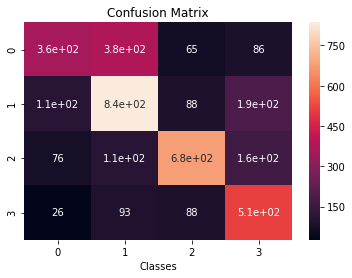

In [34]:
show_results(sharp_results, np.array(sharp_images),y_train, 324, 328)

So it appears that after improving the contrast of our images, the training set performance has gone down. This is no surprise as the pictures were altered and thus no the the same data the model "overfitted" on while training. However, a drop from 99.9% to 78.4% on the best performing model is a more than significant drop. Let's see how the test set fares after improving their contrasts

### SHARPEN TEST SET AND PREDICT

In [83]:
sharp_test = sharpen_image(xg_test)

In [91]:
sharp_test_results = sharp.restore_predict(sharp_test, path = 'Save/GRAY/grayscale_LR0.001_B0.01.ckpt-20')

INFO:tensorflow:Restoring parameters from Save/GRAY/grayscale_LR0.001_B0.01.ckpt-20


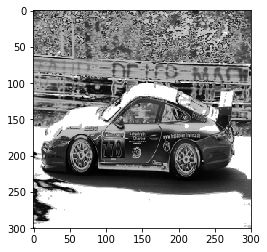

This is a Car


This is a Bird


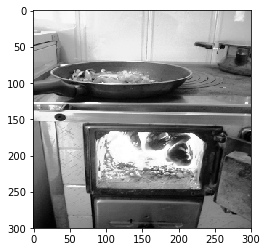

This is a Stove


This is a Bird


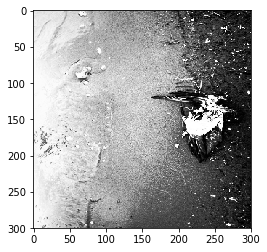

This is a Bird

Accuracy: 54.904831625183014%


F-Beta  Precision    Recall  Support
Dog    0.431655   0.600000  0.337079      178
Bird   0.595388   0.550388  0.648402      219
Stove  0.606061   0.613497  0.598802      167
Car    0.519573   0.450617  0.613445      119

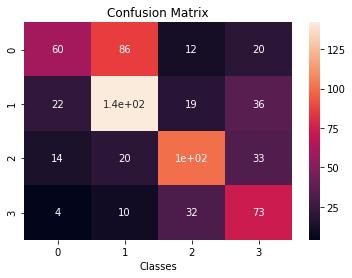

In [92]:
show_results(sharp_test_results, np.array(sharp_test), y_test, 531,536)

In [93]:
sharp_test_results = sharp.restore_predict(sharp_test, path = 'Save/GRAY/grayscale_LR0.001_B0.01.ckpt-380')

INFO:tensorflow:Restoring parameters from Save/GRAY/grayscale_LR0.001_B0.01.ckpt-380


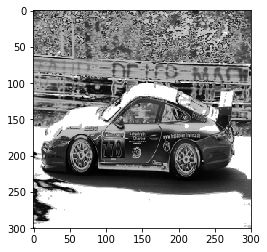

This is a Car


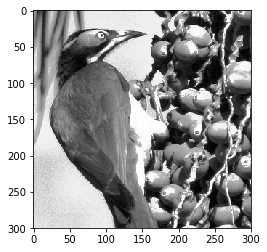

This is a Bird


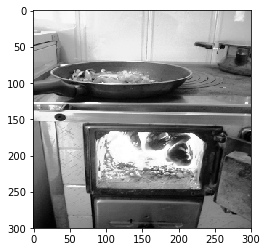

This is a Stove


This is a Bird


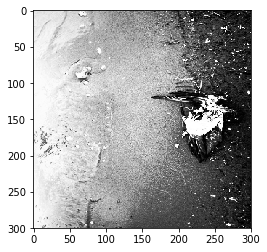

This is a Car

Accuracy: 56.95461200585652%


F-Beta  Precision    Recall  Support
Dog    0.503226   0.590909  0.438202      178
Bird   0.615385   0.593220  0.639269      219
Stove  0.609756   0.621118  0.598802      167
Car    0.520147   0.461039  0.596639      119

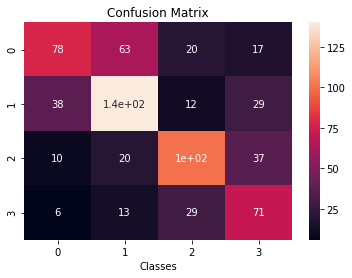

In [94]:
show_results(sharp_test_results, np.array(sharp_test), y_test, 531,536)

Again, there is a drop in performance on the sharpened test set as there was on the training set. Fortunately the drop in performance is quite as significant. Still we did extrapolate some very important qualities from this exercise. 
1. It is much faster to train grayscale models than RGB so this would allow us to prototype and hyperparameter tune more frequently with a reduced time cost
2. Sharpening all the images may reduce the overfitting effect we are currently see during the training process.
3. We have doubled our data for the model to train and be tested on by altering the original images. 

Let's now train another model on the same architecture, but now utilizing the original and sharpened images in the training process

# Train Model with Original and Sharpened Images
--------------------------------------------------
First we will need to join the original training images and the sharpened images together and save them in a h5 file for memory considerations

In [341]:
# join the sharpened and original images together in one large array
joined_xg = np.concatenate((xg,np.array(sharp_images)))
# join a copy of the labels with the labels since the training images are repeating, just sharpened
joined_y = np.concatenate((np.array(y_train),np.array(y_train)))

In [365]:
joined = h5py.File('joined_grayscale_data.h5', 'w')  
joined.create_dataset('X_train', data=joined_xg)
joined.create_dataset('y_train', data=joined_y)
joined.close()

In [7]:
data_joined = h5py.File('/home/scott//Springboard-Data-Science-Immersive/Capstone 2 Project/Convolutional Network/joined_grayscale_data.h5', 'r')

In [9]:
x = data_joined['X_train']
y = data_joined['y_train']

In [10]:
x_test = data['X_grayscale_test']
y_test = data['y_test']
y_test = [x.reshape(-1) for x in y_test]

In [13]:
joined_gray = cnnGrayScale(savefile='Save/JOINED_GRAY/grayscale_LR0.001_B0.01.ckpt', learning_rate = 0.001, beta = 0.01)

Creating CNN Graph
Tensorboard Log files stored in ./tf_logs/GRAY/
To Activate Tensorboard Session: $tensorboard --logdir "./tf_logs/GRAY/" --port 6006
Optimizer Learning Rate: 0.001
L2 Regularization Constant: 0.01
Model Save Directory: /home/scott/Springboard-Data-Science-Immersive/Capstone 2 Project/Convolutional Network/Save/JOINED_GRAY/grayscale_LR0.001_B0.01.ckpt



In [83]:
tick = time.time()
joined_gray.fit(x,y, num_epochs=300, batch_size=100)
tock = time.time()
print('Training Time: {:.2} Hrs'.format((tock-tick) / 3600))

********* TRAINING MODEL *********
Cost For Epoch 0: 417.10030937194824
Cost For Epoch 10: 70.68153363466263
Cost For Epoch 20: 50.15649336576462
Cost For Epoch 30: 45.780013859272
Cost For Epoch 40: 38.61998575925827
Cost For Epoch 50: 28.876579955220222
Cost For Epoch 60: 25.242038741707802
Cost For Epoch 70: 22.66237537562847
Cost For Epoch 80: 20.12334370613098
Cost For Epoch 90: 15.870499208569527
Cost For Epoch 100: 20.292877346277237
Cost For Epoch 110: 14.040853194892406
Cost For Epoch 120: 13.710568629205227
Cost For Epoch 130: 17.396089762449265
Cost For Epoch 140: 15.813187725841999
Cost For Epoch 150: 12.165052212774754
Cost For Epoch 160: 13.71368658542633
Cost For Epoch 170: 11.466106347739697
Cost For Epoch 180: 14.857118993997574
Cost For Epoch 190: 10.740195818245411
Cost For Epoch 200: 14.055711224675179
Cost For Epoch 210: 10.510728053748608
Cost For Epoch 220: 11.632610619068146
Cost has reached floor value @ 14.058884143829346 - Terminate learning on Epoch 229
Trai

In [30]:
train, test = model_accuracy_check(joined_gray, x, y, x_test, y_test, cmap = 'gray', total = 230)

INFO:tensorflow:Restoring parameters from Save/JOINED_GRAY/grayscale_LR0.001_B0.01.ckpt-0
INFO:tensorflow:Restoring parameters from Save/JOINED_GRAY/grayscale_LR0.001_B0.01.ckpt-0
INFO:tensorflow:Restoring parameters from Save/JOINED_GRAY/grayscale_LR0.001_B0.01.ckpt-0
INFO:tensorflow:Restoring parameters from Save/JOINED_GRAY/grayscale_LR0.001_B0.01.ckpt-10
INFO:tensorflow:Restoring parameters from Save/JOINED_GRAY/grayscale_LR0.001_B0.01.ckpt-10
INFO:tensorflow:Restoring parameters from Save/JOINED_GRAY/grayscale_LR0.001_B0.01.ckpt-10
INFO:tensorflow:Restoring parameters from Save/JOINED_GRAY/grayscale_LR0.001_B0.01.ckpt-20
INFO:tensorflow:Restoring parameters from Save/JOINED_GRAY/grayscale_LR0.001_B0.01.ckpt-20
INFO:tensorflow:Restoring parameters from Save/JOINED_GRAY/grayscale_LR0.001_B0.01.ckpt-20
INFO:tensorflow:Restoring parameters from Save/JOINED_GRAY/grayscale_LR0.001_B0.01.ckpt-30
INFO:tensorflow:Restoring parameters from Save/JOINED_GRAY/grayscale_LR0.001_B0.01.ckpt-30
IN

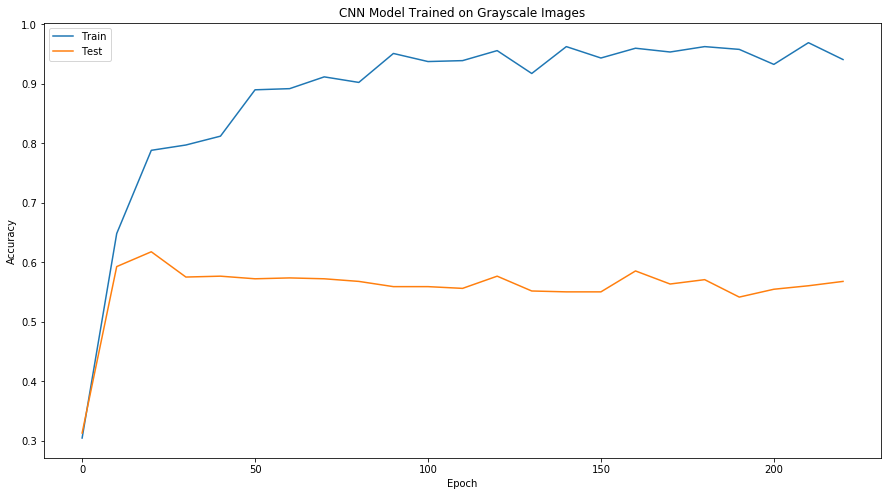

In [34]:
plt.figure(figsize = (15,8))
plt.plot(range(0,230,10), train,label = 'Train' )
plt.plot(range(0,230,10), test, label = 'Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Model Trained on Grayscale Images')
plt.show()

In [40]:
print('Training Set Highest Accuracy: {}\nEpoch: {}\nAccuracy on Test Sets Highest Accuracy Epoch {}'.format(max(train), np.argmax(train)*10, train[20]))

Training Set Highest Accuracy: 0.969089498189343
Epoch: 210
Accuracy on Test Sets Highest Accuracy Epoch 0.9326176927056389


In [39]:
print('Test Set Highest Accuracy: {}\nEpoch: {}\nAccuracy on Training Sets Highest Accuracy Epoch {}'.format(max(test), np.argmax(test)*10, test[21]))

Test Set Highest Accuracy: 0.6178623718887262
Epoch: 20
Accuracy on Training Sets Highest Accuracy Epoch 0.5607613469985359


We've doubled our training data size 7,732 traing images and it took approximately 75.5 Seconds/Epoch. This is exactly the time it took to train the 3,866 RGB images and is quite expected since we've added more data for the model to learn from. 

In [141]:
joined_gray.savefile = 'Save/JOINED_GRAY/grayscale_LR0.001_B0.01.ckpt-20'
results = joined_gray.predict(x[4000:7000])

INFO:tensorflow:Restoring parameters from Save/JOINED_GRAY/grayscale_LR0.001_B0.01.ckpt-20


This is a Stove


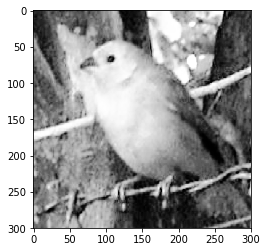

This is a Bird


This is a Bird


This is a Bird


This is a Dog

Accuracy: 82.93333333333334%


F-Beta  Precision    Recall  Support
Dog    0.798360   0.753548  0.848837      688
Bird   0.833253   0.779676  0.894737      969
Stove  0.855153   0.937405  0.786172      781
Car    0.829412   0.923581  0.752669      562

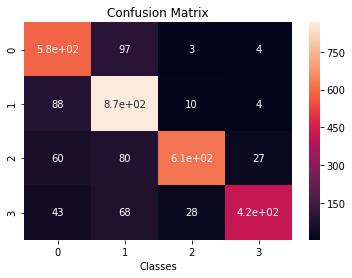

In [138]:
show_results(results, x[4000:7000], y[4000:7000],623, 628)

In [142]:
results = joined_gray.predict(x_test)

INFO:tensorflow:Restoring parameters from Save/JOINED_GRAY/grayscale_LR0.001_B0.01.ckpt-20


This is a Dog


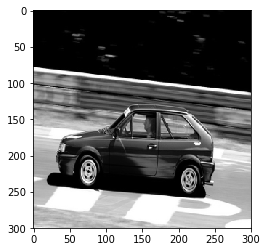

This is a Car


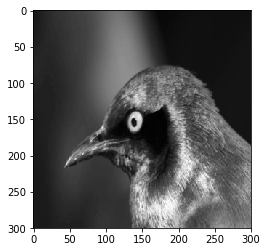

This is a Dog


This is a Stove


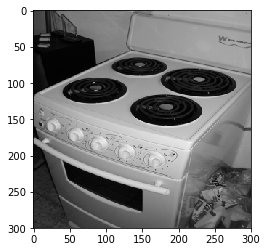

This is a Car

Accuracy: 61.78623718887262%


F-Beta  Precision    Recall  Support
Dog    0.634271   0.582160  0.696629      178
Bird   0.566416   0.627778  0.515982      219
Stove  0.660661   0.662651  0.658683      167
Car    0.617284   0.604839  0.630252      119

In [143]:
show_results(results, x_test, y_test,623, 628)

In [147]:
sharp_test = sharpen_image(x_test)

In [159]:
side_by_side(orig = x_test, new = sharp_test, num = 4)

In [160]:
results = joined_gray.predict(sharp_test)

INFO:tensorflow:Restoring parameters from Save/JOINED_GRAY/grayscale_LR0.001_B0.01.ckpt-20


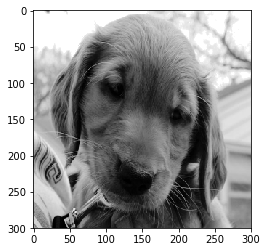

This is a Dog


This is a Dog


This is a Car


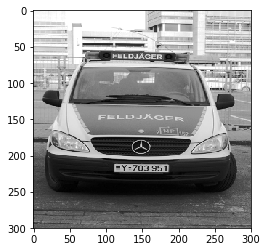

This is a Stove


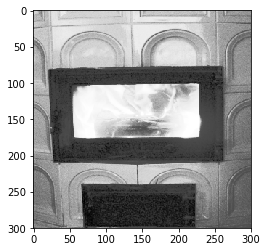

This is a Stove

Accuracy: 59.5900439238653%


F-Beta  Precision    Recall  Support
Dog    0.489028   0.553191  0.438202      178
Bird   0.625551   0.604255  0.648402      219
Stove  0.658610   0.664634  0.652695      167
Car    0.595420   0.545455  0.655462      119

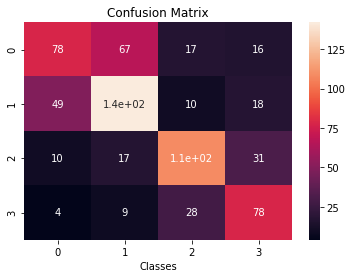

In [167]:
show_results(results, np.array(sharp_test), y_test,400, 405)

In [46]:
class smallGrayScale:
    def __init__(self, savefile=None, weight_initializer = tf.contrib.layers.xavier_initializer(seed =0), learning_rate=0.01, beta = 0.01):
        
        #Create save file path variable
        self.savefile = savefile
        #Reset any current graphs
        tf.reset_default_graph()
        #Set Random Seed
        np.random.seed(0)
        
        #Print Useful Model Information
        print('Creating CNN Graph')
        print('Tensorboard Log files stored in ./tf_logs/SMALL_GRAY/')
        print('To Activate Tensorboard Session: $tensorboard --logdir "./tf_logs/SMALL_GRAY/" --port 6006')
        print('Optimizer Learning Rate: {}'.format(learning_rate))
        print('L2 Regularization Constant: {}'.format(beta))
        
        if savefile is not None:
            print('Model Save Directory: {}\n'.format(os.path.join(os.getcwd(),savefile)))
        else:
            print('WARNING: No save directory - Model and Weights will be lost after training\n')
        
        
        #Placeholders
        self.inputs = tf.cast(tf.placeholder(dtype = tf.float64, shape = [None, 300,300,1], name = 'X'), tf.float32)
        self.labels = tf.cast(tf.placeholder(dtype = tf.float64, shape = [None,4], name = 'y'), tf.float32)
        self.hold_prob = tf.placeholder(tf.float32)
        
        #Convolutional Layer #1
        with tf.name_scope('Convolution_layer_1'):
            self.W1 = tf.get_variable(dtype = tf.float32, name = 'W1', shape = [7,7,1,10], initializer=weight_initializer)
            self.b1 = tf.Variable(tf.constant(0.1, shape = [10]))
            self.C1 = tf.nn.conv2d(input = self.inputs, filter=self.W1, strides = [1,2,2,1], padding='SAME', name = 'C1')
            self.A1 = tf.nn.relu(features = self.C1, name = 'A1') + self.b1
            self.P1 = tf.nn.max_pool(self.A1, ksize = [1,2,2,1], padding = 'VALID', strides = [1,2,2,1], name = 'Pool_1')

        #Convolutional Layer #2
        with tf.name_scope('Convolution_layer_2'):
            self.W2 = tf.get_variable(dtype = tf.float32, name = 'W2', shape = [4,4,self.P1.shape[3],20], initializer=weight_initializer)
            self.b2 = tf.Variable(tf.constant(0.1, shape = [20]))
            self.C2 = tf.nn.conv2d(input = self.P1, filter = self.W2, strides = [1,2,2,1], padding = 'SAME', name = 'C2')
            self.A2 = tf.nn.relu(features = self.C2 , name = 'A2') + self.b2
            self.P2 = tf.nn.max_pool(self.A2, ksize = [1,2,2,1], padding = 'VALID', strides = [1,2,2,1], name = 'Pool_2')
        
        #Fully Connected Layer
        with tf.name_scope('Fully_connected_layer'):
            self.flatten = tf.contrib.layers.flatten(self.P2)
            self.Z1 = tf.contrib.layers.fully_connected(self.flatten, num_outputs = 4, activation_fn = None)
            self.hold_out_fc = tf.nn.dropout(self.Z1, keep_prob = self.hold_prob)

        #Prediction Operation
        with tf.name_scope('Prediction_Op'):
            self.predictions = tf.argmax(tf.nn.softmax(logits = self.hold_out_fc), 1)
            self.correct_prediction = tf.equal(self.predictions, tf.argmax(self.labels, 1))
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, "float"))
            
        #Training Operation   
        with tf.name_scope('Training_Op'):
            self.regularizers = tf.nn.l2_loss(self.W1) + tf.nn.l2_loss(self.W2)
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.Z1, labels = self.labels))
            self.cost = tf.reduce_mean(self.loss + (beta * self.regularizers)) 
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)
            
            
            
        #Gloabal Variables Initializer
        with tf.name_scope('Initializers'):
            self.init = tf.global_variables_initializer()
            self.saver = tf.train.Saver(max_to_keep=500, filename='Step_number')
        
        #Log Files for Tensorboard Viewing
        with tf.name_scope('Log_Writers'):
            cost_summary_1 = tf.summary.scalar('Cost', self.cost)
            accuracy_summary = tf.summary.scalar('Accuracy', self.accuracy)
            weights_summary1 = tf.summary.histogram('Weights_1',self.W1)
            weights_summary2 = tf.summary.histogram('Weights_2',self.W2)
            conv1_summary_channels_1 = tf.summary.image('First_Conv_Layer_1',self.C1[:,:,:,0:1], max_outputs = 2)
            conv1_summary_channels_2 = tf.summary.image('First_Conv_Layer_2',self.C1[:,:,:,1:2], max_outputs = 2)
            conv1_summary_channels_3 = tf.summary.image('First_Conv_Layer_3',self.C1[:,:,:,2:3], max_outputs = 2)
            conv1_summary_channels_4 = tf.summary.image('First_Conv_Layer_4',self.C1[:,:,:,3:4], max_outputs = 2)
            conv1_summary_channels_5 = tf.summary.image('First_Conv_Layer_5',self.C1[:,:,:,4:5], max_outputs = 2)
            conv1_summary_channels_6 = tf.summary.image('First_Conv_Layer_6',self.C1[:,:,:,5:6], max_outputs = 2)
            conv1_summary_channels_7 = tf.summary.image('First_Conv_Layer_7',self.C1[:,:,:,6:7], max_outputs = 2)
            conv1_summary_channels_8 = tf.summary.image('First_Conv_Layer_8',self.C1[:,:,:,7:8], max_outputs = 2)
            conv1_summary_channels_9 = tf.summary.image('First_Conv_Layer_9',self.C1[:,:,:,8:9], max_outputs = 2)
            conv1_summary_channels_10 = tf.summary.image('First_Conv_Layer_10',self.C1[:,:,:,9:10], max_outputs = 2)

            conv2_summary_channels_1 = tf.summary.image('Second_Conv_Layer_1',self.C2[:,:,:,0:1], max_outputs = 2)
            conv2_summary_channels_2 = tf.summary.image('Second_Conv_Layer_2',self.C2[:,:,:,1:2], max_outputs = 2)
            conv2_summary_channels_3 = tf.summary.image('Second_Conv_Layer_3',self.C2[:,:,:,2:3], max_outputs = 2)
            conv2_summary_channels_4 = tf.summary.image('Second_Conv_Layer_4',self.C2[:,:,:,3:4], max_outputs = 2)
            conv2_summary_channels_5 = tf.summary.image('Second_Conv_Layer_5',self.C2[:,:,:,4:5], max_outputs = 2)
            conv2_summary_channels_6 = tf.summary.image('Second_Conv_Layer_6',self.C2[:,:,:,5:6], max_outputs = 2)
            conv2_summary_channels_7 = tf.summary.image('Second_Conv_Layer_7',self.C2[:,:,:,6:7], max_outputs = 2)
            conv2_summary_channels_8 = tf.summary.image('Second_Conv_Layer_8',self.C2[:,:,:,7:8], max_outputs = 2)
            conv2_summary_channels_9 = tf.summary.image('Second_Conv_Layer_9',self.C2[:,:,:,8:9], max_outputs = 2)
            conv2_summary_channels_10 = tf.summary.image('Second_Conv_Layer_10',self.C2[:,:,:,9:10], max_outputs = 2)
            conv2_summary_channels_11 = tf.summary.image('Second_Conv_Layer_11',self.C2[:,:,:,10:11], max_outputs = 2)
            conv2_summary_channels_12 = tf.summary.image('Second_Conv_Layer_12',self.C2[:,:,:,11:12], max_outputs = 2)
            conv2_summary_channels_13 = tf.summary.image('Second_Conv_Layer_13',self.C2[:,:,:,12:13], max_outputs = 2)
            conv2_summary_channels_14 = tf.summary.image('Second_Conv_Layer_14',self.C2[:,:,:,13:14], max_outputs = 2)
            conv2_summary_channels_15 = tf.summary.image('Second_Conv_Layer_15',self.C2[:,:,:,14:15], max_outputs = 2)
            conv2_summary_channels_16 = tf.summary.image('Second_Conv_Layer_16',self.C2[:,:,:,15:16], max_outputs = 2)
            conv2_summary_channels_17 = tf.summary.image('Second_Conv_Layer_17',self.C2[:,:,:,16:17], max_outputs = 2)
            conv2_summary_channels_18 = tf.summary.image('Second_Conv_Layer_18',self.C2[:,:,:,17:18], max_outputs = 2)
            conv2_summary_channels_19 = tf.summary.image('Second_Conv_Layer_19',self.C2[:,:,:,18:19], max_outputs = 2)
            conv2_summary_channels_20 = tf.summary.image('Second_Conv_Layer_20',self.C2[:,:,:,19:20], max_outputs = 2)


            self.merged_summaries = tf.summary.merge_all()
        
        
        
    def fit(self,x,y, num_epochs = 100, batch_size = 50):
        print('********* TRAINING MODEL *********')
        num_of_batches = int(x.shape[0] / batch_size)
        prev_cost = 0
        cost_tracker = 0
        cost_summary_2 = tf.summary.scalar('Cost_2', self.cost)
        accuracy_summary_2 = tf.summary.scalar('Accuracy_2', self.accuracy)
        with tf.Session() as sess:
            #Initialize all Global Variables
            sess.run(self.init)

            #Initialize log writer for Tensorboard
            writer = tf.summary.FileWriter('tf_logs/SMALL_GRAY/', sess.graph)
            for i in range(num_epochs):
                #Initialize useful variables
                cost = 0
                batch_start = 0
                
                for j in range(num_of_batches):
                    #Train the model and track cost
                    _,c = sess.run([self.optimizer,self.cost], feed_dict={
                                                            self.inputs:x[batch_start:batch_start + batch_size],
                                                            self.labels:y[batch_start:batch_start + batch_size],
                                                            self.hold_prob:0.5
                                                            })
                    
                    batch_start+=batch_size
                    cost+=c
                    
                
                    
                #Every 10 epochs, ,  and 
                if i%10 == 0:
                    #print the cost
                    print('Cost For Epoch {}: {}'.format(i,cost))
                    
                    #save a checkpoint of the model
                    self.saver.save(sess, self.savefile,global_step=i)
                    
                    #write log files for tensorboard
                    
                    summary = sess.run(self.merged_summaries, feed_dict = {self.inputs:x[:3866], self.labels:y[:3866], self.hold_prob:1})
                    cost_2, accuracy_2 = sess.run([cost_summary_2,accuracy_summary_2], feed_dict = {self.inputs:x[3866:], self.labels:y[3866:], self.hold_prob:1})
                    writer.add_summary(summary, i)
                    writer.add_summary(cost_2,i)
                    writer.add_summary(accuracy_2,i)
        
        
   
            
        
    
    
    def predict(self, x):
        with tf.Session() as sess:
            #Restore last saved model checkpoint
            self.saver.restore(sess, self.savefile)
            #Run feed forward part of the graph for predictions
            preds, w1, w2, w3 = sess.run([self.predictions,self.W1, self.W2, self.W3], feed_dict = {self.inputs:x, self.hold_prob:1})
            results = {'predictions':preds, 'w1':w1, 'w2':w2, 'w3':w3}
            return results
        
        
    def restore_predict(self, x, path):
        with tf.Session() as sess:
            self.saver.restore(sess, path)
            preds, w1, w2, w3 = sess.run([self.predictions,self.W1, self.W2, self.W3], feed_dict = {self.inputs:x, self.hold_prob:1})
            results = {'predictions':preds, 'w1':w1, 'w2':w2, 'w3':w3}
            return results


In [47]:
small = smallGrayScale(savefile='Save/SMALL_GRAY/grayscale_LR0.01_B0.1.ckpt', learning_rate = 0.01, beta = 0.1)

Creating CNN Graph
Tensorboard Log files stored in ./tf_logs/SMALL_GRAY/
To Activate Tensorboard Session: $tensorboard --logdir "./tf_logs/SMALL_GRAY/" --port 6006
Optimizer Learning Rate: 0.01
L2 Regularization Constant: 0.1
Model Save Directory: /home/scott/Springboard-Data-Science-Immersive/Capstone 2 Project/Convolutional Network/Save/SMALL_GRAY/grayscale_LR0.01_B0.1.ckpt



In [49]:
tick = time.time()
small.fit(x,y, num_epochs=500, batch_size=100)
tock = time.time()
print('Training Time: {:.2} Hrs'.format((tock-tick) / 3600))

********* TRAINING MODEL *********
Cost For Epoch 0: 923.2262668609619
Cost For Epoch 10: 125.55742383003235
Cost For Epoch 20: 116.54170298576355
Cost For Epoch 30: 111.32521891593933
Cost For Epoch 40: 109.63588666915894
Cost For Epoch 50: 108.29965031147003
Cost For Epoch 60: 140.45121335983276
Cost For Epoch 70: 129.43177151679993
Cost For Epoch 80: 150.98724806308746
Cost For Epoch 90: 132.11376476287842
Cost For Epoch 100: 189.18502044677734
Cost For Epoch 110: 257.4014811515808
Cost For Epoch 120: 197.035418510437
Cost For Epoch 130: 267.3683326244354
Cost For Epoch 140: 179.47703742980957
Cost For Epoch 150: 189.04390859603882
Cost For Epoch 160: 174.4959032535553
Cost For Epoch 170: 150.77596521377563
Cost For Epoch 180: 145.50436758995056
Cost For Epoch 190: 188.01004576683044
Cost For Epoch 200: 129.06886851787567
Cost For Epoch 210: 206.13440775871277
Cost For Epoch 220: 185.84951519966125
Cost For Epoch 230: 180.89117884635925
Cost For Epoch 240: 143.75007712841034
Cost Fo